In [12]:
#Common Library
import numpy as np
import pandas as pd
from __future__ import division
from datetime import datetime,timedelta
from dateutil import parser
#import time
from time import time
#Sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
#regression evaluation
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#Matplotlib
import matplotlib.pyplot as plt
# Anfis
#import anfis
#from membership import membershipfunction, mfDerivs

In [13]:
def totimestamp(dt, epoch=datetime(1970,1,1)):
    td = dt - epoch
    # return td.total_seconds()
    return (td.microseconds + (td.seconds + td.days * 86400) * 10**6) / 10**6 

def DataPrepare(df):
    df['TL BASED'][0] = 'ISE.TL'
    df['USD BASED'][0] = 'ISE.USD'
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    df.rename(columns={'ISE': 'ISE.TL', 'ISE': 'ISE.USD'}, inplace=True)

    #col_target = ['ISE.TL', 'ISE.USD']
    col_target = ['ISE.TL']
    target = df[col_target]
    data = df.drop(['ISE.TL', 'ISE.USD'], axis=1)

    data['date'] = pd.to_datetime(data['date'])
    #print(data['date'][0])
    ms = []
    for i in range(1, len(data['date'])+1):
        #print(int(totimestamp(data['date'][i])))
        ms.append(int(totimestamp(data['date'][i])))
        
    data['date'] = ms

    return data, target

In [15]:
def ReadData():
    df = pd.read_csv('IstanbulStockExchangeUCI/IstanbulStockExchangeUCI.csv', delimiter=';')
    #print(df.head())
    return DataPrepare(df)

#data, target = ReadData()

In [16]:
def CreateFeatureSelectionModel(x_train, y_train, threshold = 0.1):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import SelectFromModel
    sfm_m = RandomForestRegressor(max_depth=30, random_state=0)
    sfm = SelectFromModel(sfm_m, threshold=threshold)
    sfm.fit(x_train, y_train)
    return sfm

def DoFeatureSelection(model, data):
    return model.transform(data)

def DoInverseFeatureSelection(mode, data):
    return model.inverse_transform(data)


In [17]:
def CreateDataScaleModel(x_train, y_train):
    from sklearn.preprocessing import MinMaxScaler
    scaler_x = MinMaxScaler()
    scaler_x.fit(x_train)
    scaler_y = MinMaxScaler()
    scaler_y.fit(y_train)
    return scaler_x, scaler_y
    
    
def DataScale(model, data):
    return model.transform(data)

In [21]:
def GetData(DoFS = True):
    data, target = ReadData()
    
    sfm = CreateFeatureSelectionModel(data, target, 0.25)
    if DoFS == True:
        X = DoFeatureSelection(sfm, data)
    else:
        X = data.values
    Y = target.values[:,0]
    aa = np.hstack([X,target.values])
    df = pd.DataFrame(data=aa)
    #print(df.head())
    df.to_csv('reduced.csv')
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    x_train = x_train.astype(float)
    x_test = x_test.astype(float)
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    #scale_x, scale_y = CreateDataScaleModel(x_train, y_train)
    #x_train = DataScale(scale_x, x_train)
    #y_train = DataScale(scale_y, y_train)
    return x_train, x_test, y_train, y_test

#aaa = GetData()

In [205]:
def ConstructFISMembership(X, Y, sigma_lb, sigma_ub):
    mf = []

    for i in range(0, len(X[0])):
        _min = np.min(X[:,i])
        _max = np.max(X[:,i])
        _mean = np.mean(X[:,i])
        vmf = []
        vmf.append(['gaussmf',{'mean':_min,'sigma':random.uniform(sigma_lb, sigma_ub)}])
        vmf.append(['gaussmf',{'mean':random.uniform(_min, _max),'sigma':random.uniform(sigma_lb, sigma_ub)}])
        vmf.append(['gaussmf',{'mean':_max,'sigma':random.uniform(sigma_lb, sigma_ub)}])
        mf.append(vmf)

    print(mf)
    mfc = anfis.membership.membershipfunction.MemFuncs(mf)
    return mfc

In [206]:
def CreateANFISModel(X, Y, sigma_lb=1.25, sigma_ub=5, epoch=30):
    start=datetime.now()
    mfc = ConstructFISMembership(X, Y, sigma_lb=sigma_lb, sigma_ub=sigma_ub)
    anf = anfis.anfis.ANFIS(X, Y, mfc)
    anf.trainHybridJangOffLine(epochs=epoch)
    Y_ = anfis.anfis.predict(anf, X)[:,0]
    print('train var : ' + str(explained_variance_score(Y, Y_)))
    print('train r2 : ' + str(r2_score(Y, Y_)))
    print('train rmse : ' + str(np.sqrt(mean_squared_error(Y, Y_))))
    print(datetime.now()-start)
    return anf

In [207]:
def ANFISEvaluate(model, X, Y):
    y_pred = anfis.anfis.predict(model, X)[:,0]
    y_true = Y
    print(y_pred[0:10])
    print(y_true[0:10])
    #y_pred = scaler_y.inverse_transform(y_pred)
    #y_test = scaler_y.inverse_transform(y_test)
    print('test var : ' + str(explained_variance_score(y_true, y_pred)))
    print('test r2 : ' + str(r2_score(y_true, y_pred)))
    print('test rmse : ' + str(np.sqrt(mean_squared_error(y_true, y_pred))))
    print round(anf.consequents[-1][0],6)
    print round(anf.consequents[-2][0],6)
    print round(anf.fittedValues[9][0],6)
    if round(anf.consequents[-1][0],6) == -5.275538 and round(anf.consequents[-2][0],6) == -1.990703 and round(anf.fittedValues[9][0],6) == 0.002249:
        print 'test is good'
    anf.plotErrors()
    anf.plotResults()
    x_plot = range(0, len(X))
    plt.scatter(x_plot, y_pred, marker='^', color='blue')
    plt.scatter(x_plot, y_true, marker='o', color='red')
    plt.show()

[[['gaussmf', {'sigma': 4.998781093363696, 'mean': -0.048816774}], ['gaussmf', {'sigma': 2.9443472994931685, 'mean': -0.03410515859748707}], ['gaussmf', {'sigma': 2.36296495300247, 'mean': 0.067042467}]]]
current error:  0.060286840073185494
current error:  0.06028683652151396
current error:  0.06028683118963364
current error:  0.06028682374992017
current error:  0.060286812660858655
current error:  0.060286796094469394
current error:  0.06028677092962858
current error:  0.06028673127994375
current error:  0.060286664145403485
current error:  0.0602865312104708
current error:  0.06028609464339288
current error:  0.06028450676482472
current error:  0.06028390479117373
current error:  0.06028321766139248
current error:  0.06028242505182874
current error:  0.060281507566983805
current error:  0.060280446615733285
current error:  0.06027922567230598
current error:  0.060277832750079696
current error:  0.06027626416417409
current error:  0.06027452955577869
current error:  0.060272657779412

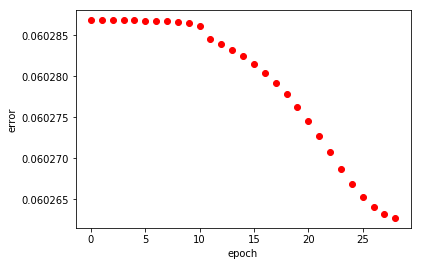

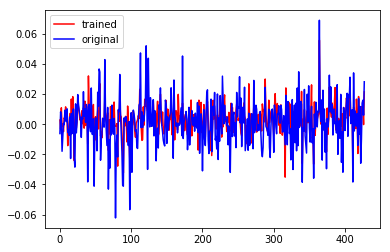

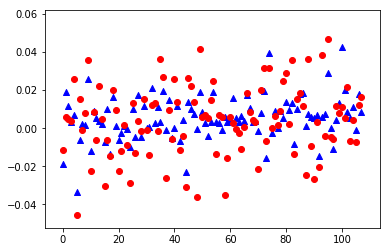

In [208]:
x_train, x_test, y_train, y_test = GetData()
anf = CreateANFISModel(x_train, y_train, sigma_lb=0.75, sigma_ub=5)
ANFISEvaluate(anf, x_test, y_test)

In [5]:
def CreateSVRModel(X, Y, C=1.0, epsilon=0.01):
    if len(X) != len(Y):
        print('x and y not have same size')
        return
    #start=datetime.now()
    clf = SVR(kernel='rbf', degree=3, C=C, epsilon=epsilon)
    #clf = RandomForestRegressor(max_depth=20, random_state=0)
    clf.fit(X, Y)
    Y_ = clf.predict(X)
    #print('train var : ' + str(explained_variance_score(Y, Y_)))
    #print('train r2 : ' + str(r2_score(Y, Y_)))
    #print('train rmse : ' + str(np.sqrt(mean_squared_error(Y, Y_))))
    #print(datetime.now()-start)
    return clf

def SVMEvaluate(model, X, Y):
    if len(X) != len(Y):
        print('x and y not have same size')
        return
    y_pred = model.predict(X)
    y_true = Y
    print(y_pred[13:23])
    print(y_true[13:23])
    print('test var : ' + str(explained_variance_score(y_true, y_pred)))
    print('test r2 : ' + str(r2_score(y_true, y_pred)))
    print('test rmse : ' + str(np.sqrt(mean_squared_error(y_true, y_pred))))
    x_plot = range(0, len(Y))
    plt.scatter(x_plot, y_pred, marker='^', color='blue')
    plt.scatter(x_plot, y_true, marker='o', color='red')
    plt.show()

            0             1             2             3             4  \
0  1231113600  -0.004679315   0.002193419   0.003894376             0   
1  1231200000   0.007786738   0.008455341   0.012865611   0.004162452   
2  1231286400  -0.030469134  -0.017833062  -0.028734593   0.017292932   
3  1231372800   0.003391364  -0.011726277  -0.000465999  -0.040061309   
4  1231459200  -0.021533208  -0.019872754  -0.012709717  -0.004473502   

              5             6             7             8  
0   0.031190229   0.012698039   0.028524462   0.035753708  
1    0.01891958   0.011340652   0.008772644   0.025425873  
2  -0.035898576  -0.017072795  -0.020015412   -0.02886173  
3   0.028283152  -0.005560959  -0.019423778  -0.062208079  
4   -0.00976388  -0.010988634  -0.007802212   0.009859905  
train var : 0.7555689052715582
train r2 : 0.7533843059609298
train rmse : 0.0077799592458622545
0:00:00.004865
[0.00031326 0.00031326 0.00031326 0.00031326 0.00031326 0.00031326
 0.00031326 0.00031326 

/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


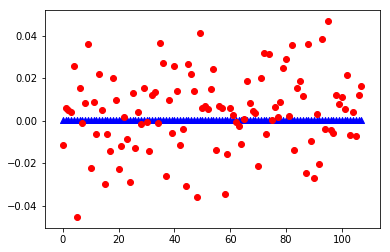

In [40]:
x_train, x_test, y_train, y_test = GetData(False)
svr_model = CreateSVRModel(x_train, y_train)
SVMEvaluate(svr_model, x_test, y_test)

In [215]:
import math
from optimal import GenAlg
from optimal import Problem
from optimal import helpers

SVM_ACO_Points = []

def SVMGAEvaluate(model, X, Y):
    if len(X) != len(Y):
        print('x and y not have same size')
        return
    y_pred = model.predict(X)
    y_true = Y
    var = explained_variance_score(y_true, y_pred)
    print('test var : ' + str(var))
    print('test r2 : ' + str(r2_score(y_true, y_pred)))
    print('test rmse : ' + str(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('\n')
    return var
    #x_plot = range(0, len(X))
    #plt.scatter(x_plot, y_pred, marker='^', color='blue')
    #plt.scatter(x_plot, y_true, marker='o', color='red')
    #plt.show()

def decode_svmga_search_space(binary):
    c = helpers.binary_to_float(binary[0:16], 1, 20.0)
    epsilon = helpers.binary_to_float(binary[16:32], 0.001, 0.01)
    return c, epsilon

def svmga_fitness(solution):
    c, epsilon = solution
    
    x_train, x_test, y_train, y_test = GetData()
    
    svr_model = CreateSVRModel(x_train, y_train, C=c, epsilon=epsilon)
    SVM_ACO_Points.append((c, epsilon))
    output = SVMGAEvaluate(svr_model, x_test, y_test)
    finished = output
    fitness = output
    return fitness, finished

def SVMGA():
    svmga = Problem(svmga_fitness, decode_function=decode_svmga_search_space)
    my_genalg = GenAlg(32)
    best_solution = my_genalg.optimize(svmga, max_iterations=1000000)
    print best_solution

In [4]:
from optimal import GenAlg
from optimal import Problem
from optimal import helpers


SyntaxError: invalid syntax (optimize.py, line 57)

In [216]:
start=datetime.now()
SVMGA()
print(datetime.now()-start)
SVM_ACO_Points

train var : 0.42655395668839635
train r2 : 0.42649626293611187
train rmse : 0.01186410803668635
0:00:00.006428
test var : 0.42677333190937383
test r2 : 0.42525435202369477
test rmse : 0.013793785732784558


train var : 0.4268099378788439
train r2 : 0.4259404710467535
train rmse : 0.011869855495496556
0:00:00.006341
test var : 0.42810181545152204
test r2 : 0.4278304216522173
test rmse : 0.01376283842714876


train var : 0.42497681655841824
train r2 : 0.4249530202830881
train rmse : 0.011880059891798652
0:00:00.007151
test var : 0.4240990817654826
test r2 : 0.4211482826988414
test rmse : 0.013842970482927762


train var : 0.42469755102937967
train r2 : 0.4243335563060452
train rmse : 0.0118864570111197
0:00:00.007550
test var : 0.42366633854644775
test r2 : 0.42249471888074264
test rmse : 0.013826861411296774


train var : 0.4266694183255697
train r2 : 0.4265938490331356
train rmse : 0.011863098608867232
0:00:00.007189
test var : 0.4269737334383963
test r2 : 0.4242360457780562
test rmse 

[(12.335927367055772, 0.005152346074616618),
 (6.29048599984741, 0.0053127489127946905),
 (14.996246280613413, 0.003971572442206455),
 (15.36821545738918, 0.003103913939116503),
 (10.968078126192111, 0.004532982375829709),
 (12.1570458533608, 0.0023730373083085373),
 (7.7145799954222944, 0.002088075074387732),
 (4.7681086442359035, 0.0042011902037079425),
 (13.505470359349966, 0.0013970244907301442),
 (8.955443656061647, 0.00209727626459144),
 (8.899778744182498, 0.0033360036621652555),
 (1.6456549935149156, 0.0023525749599450675),
 (4.958587014572366, 0.008378530556191349),
 (18.63852903028916, 0.0011597161821927215),
 (1.3360189211871518, 0.0038475623712520028),
 (14.023849851224538, 0.005140123598077364),
 (2.3492942702372774, 0.0015268024719615474),
 (9.261310749980927, 0.0053985809109636075),
 (4.968154421301595, 0.004791165026321813),
 (12.33505760280766, 0.008487708857862212)]

train var : 0.42578319343202387
train r2 : 0.4243798618840774
train rmse : 0.011885978938845718
0:00:00.001236
test var : 0.4277851295292274
test r2 : 0.42776759787098606
test rmse : 0.013763593980965726


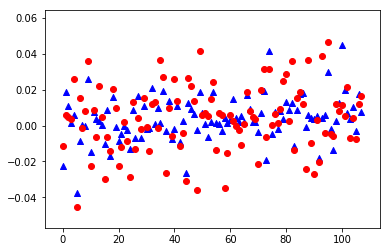

In [1019]:
x_train, x_test, y_train, y_test = GetData()
svr_model = CreateSVRModel(x_train, y_train, C=19.989852750438697, epsilon=0.024782330052643627)
SVMEvaluate(svr_model, x_test, y_test)

In [211]:
import math
from optimal import GenAlg
from optimal import Problem
from optimal import helpers

def ANFISGAEvaluate(model, X, Y):
    if len(X) != len(Y):
        print('x and y not have same size')
        return
    y_pred = anfis.anfis.predict(model, X)
    y_true = Y
    var = explained_variance_score(y_true, y_pred)
    print('test var : ' + str(var))
    print('test r2 : ' + str(r2_score(y_true, y_pred)))
    print('test rmse : ' + str(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('\n')
    anf.plotErrors()
    anf.plotResults()
    x_plot = range(0, len(X))
    plt.scatter(x_plot, y_pred, marker='^', color='blue')
    plt.scatter(x_plot, y_true, marker='o', color='red')
    plt.show()
    return var

def decode_anfisga_search_space(binary):
    sigma_lb = helpers.binary_to_float(binary[0:16], 0.25, 5)
    sigma_ub = helpers.binary_to_float(binary[16:32], 5, 10)
    return sigma_lb, sigma_ub

def anfisga_fitness(solution):
    sigma_lb, sigma_ub = solution
    
    x_train, x_test, y_train, y_test = GetData()
    anf = CreateANFISModel(x_train, y_train, sigma_lb=sigma_lb, sigma_ub=sigma_ub)
    output = ANFISGAEvaluate(anf, x_test, y_test)
    finished = output
    fitness = output
    return fitness, finished

def ANFISGA():
    anfisga = Problem(anfisga_fitness, decode_function=decode_anfisga_search_space)
    my_genalg = GenAlg(32)
    best_solution = my_genalg.optimize(anfisga)
    print best_solution

[[['gaussmf', {'sigma': 4.889931304339412, 'mean': -0.048816774}], ['gaussmf', {'sigma': 2.7977609370955783, 'mean': -0.02108050789823439}], ['gaussmf', {'sigma': 3.285936260975517, 'mean': 0.067042467}]]]
current error:  0.060286839143377846
current error:  0.06028679200845849
current error:  0.06028678096228063
current error:  0.06028676971775199
current error:  0.060286757055739326
current error:  0.060286742770908563
current error:  0.06028672663043044
current error:  0.060286708367923075
current error:  0.0602866876765071
current error:  0.06028666420050356
current error:  0.06028663752527753
current error:  0.06028660716462014
current error:  0.06028657254487027
current error:  0.06028653298473933
current error:  0.06028648766940316
current error:  0.0602864356169245
current error:  0.06028637563428452
current error:  0.060286306259225264
current error:  0.060286225682501124
current error:  0.06028613164279245
current error:  0.06028602128302442
current error:  0.0602858909515862

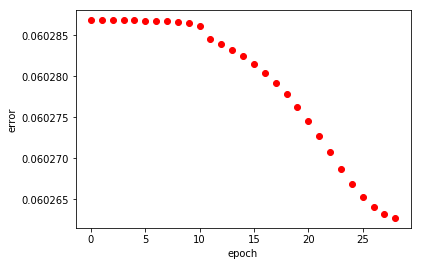

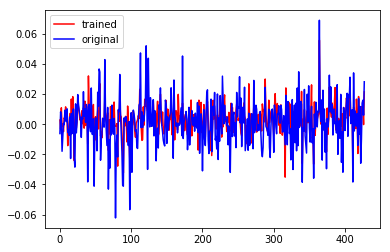

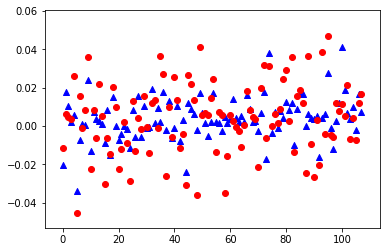

[[['gaussmf', {'sigma': 3.304956040980283, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.569522669146135, 'mean': -0.032513124842335164}], ['gaussmf', {'sigma': 3.5436275076099344, 'mean': 0.067042467}]]]
current error:  0.06028683897516969
current error:  0.06028682275336311
current error:  0.06028681274609245
current error:  0.060286802748923125
current error:  0.060286791559218206
current error:  0.06028677899733312
current error:  0.06028676487394974
current error:  0.06028674897907947
current error:  0.06028673107472336
current error:  0.06028671088809407
current error:  0.06028668810424284
current error:  0.06028666235742964
current error:  0.0602866332206801
current error:  0.060286600192918684
current error:  0.060286562682909856
current error:  0.06028651998902221
current error:  0.060286471273468735
current error:  0.06028641552919794
current error:  0.06028635153688772
current error:  0.06028627780846274
current error:  0.0602861925120139
current error:  0.0602860933707304

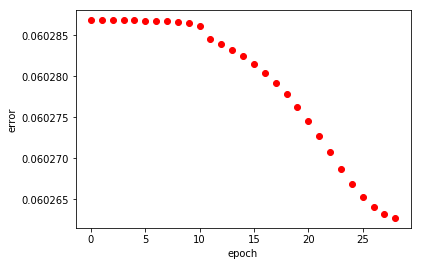

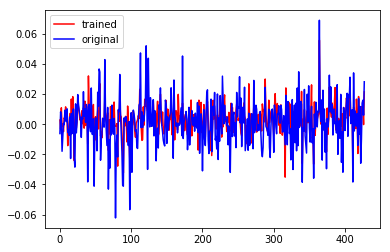

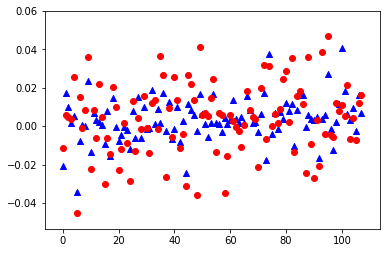

[[['gaussmf', {'sigma': 5.755833609985489, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.220074228299422, 'mean': 0.048386771219913104}], ['gaussmf', {'sigma': 5.02790534299197, 'mean': 0.067042467}]]]
current error:  0.06028684140509332
current error:  0.06028684110240354
current error:  0.06028684067625373
current error:  0.06028684010913146
current error:  0.06028683929831324
current error:  0.060286838144087335
current error:  0.0602868365005964
current error:  0.06028683414983206
current error:  0.06028683075681076
current error:  0.060286825788829324
current error:  0.060286818362914156
current error:  0.060286806942877885
current error:  0.06028678870923544
current error:  0.06028675820530879
current error:  0.060286704403704414
current error:  0.06028660420520494
current error:  0.06028640412469143
current error:  0.06028593111756036
current error:  0.060283736211780306
current error:  0.060278039161474936
current error:  0.06027493661373632
current error:  0.0602715594933197

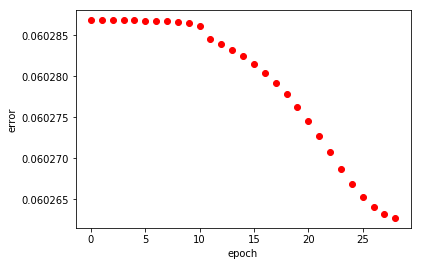

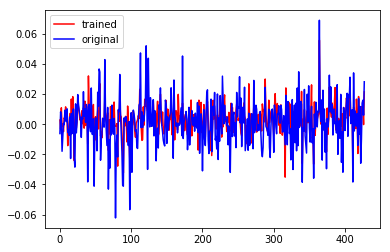

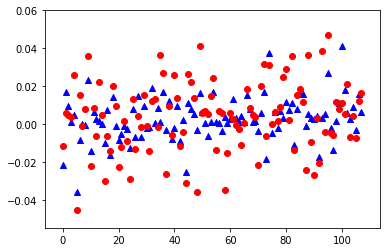

[[['gaussmf', {'sigma': 3.730988584914357, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.451273622005166, 'mean': -0.01748222421256787}], ['gaussmf', {'sigma': 3.5479408299516026, 'mean': 0.067042467}]]]
current error:  0.06028684009755511
current error:  0.06028683285002829
current error:  0.06028678939113437
current error:  0.060286755561593366
current error:  0.06028672688969075
current error:  0.06028669741695336
current error:  0.060286665754720685
current error:  0.06028663097588216
current error:  0.06028659220638761
current error:  0.06028654848436123
current error:  0.06028649866789299
current error:  0.0602864413414688
current error:  0.06028637469717412
current error:  0.06028629636798258
current error:  0.06028620318148885
current error:  0.06028609078380789
current error:  0.06028595304980937
current error:  0.06028578113811065
current error:  0.06028556195364201
current error:  0.06028527563863787
current error:  0.06028489156085705
current error:  0.0602843623187401
cu

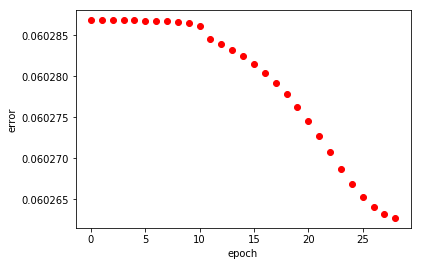

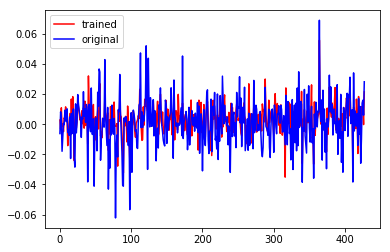

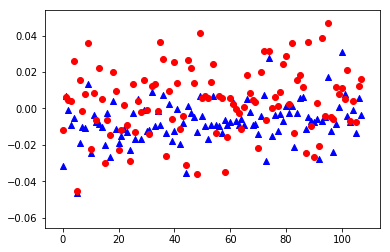

[[['gaussmf', {'sigma': 4.503072446426355, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.603916633040487, 'mean': 0.04774452080208579}], ['gaussmf', {'sigma': 4.1661313545822285, 'mean': 0.067042467}]]]
current error:  0.06028684071274238
current error:  0.060286826342966705
current error:  0.06028680862790782
current error:  0.06028679712588395
current error:  0.06028678538259884
current error:  0.06028677293612865
current error:  0.06028675949715263
current error:  0.06028674481557941
current error:  0.0602867286384832
current error:  0.06028671068877042
current error:  0.060286690649235
current error:  0.06028666814678305
current error:  0.060286642734073616
current error:  0.06028661386623806
current error:  0.060286580869883366
current error:  0.06028654290044545
current error:  0.06028649888182677
current error:  0.06028644741858896
current error:  0.06028638666439948
current error:  0.060286314118397244
current error:  0.06028622629815992
current error:  0.06028611819214151
cu

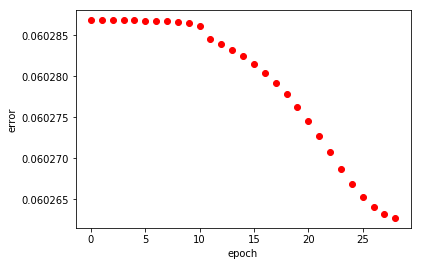

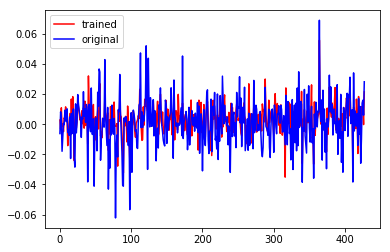

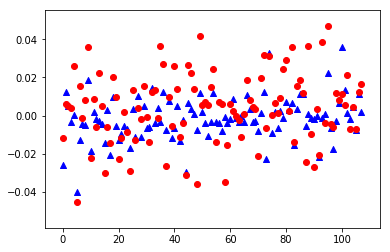

[[['gaussmf', {'sigma': 7.9449242014073675, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.457030285274596, 'mean': -0.02814490527532351}], ['gaussmf', {'sigma': 5.431266387376427, 'mean': 0.067042467}]]]
current error:  0.06028684144538758
current error:  0.06028684084787987
current error:  0.06028683927169642
current error:  0.0602868339963147
current error:  0.060286642108375775
current error:  0.060286624105291
current error:  0.06028660194329919
current error:  0.06028657391516934
current error:  0.06028653707075739
current error:  0.06028648567122548
current error:  0.0602864062778199
current error:  0.0602862546913947
current error:  0.06028566389076822
current error:  0.06028265438950058
current error:  0.06027244323903409
current error:  0.060270304201567745
current error:  0.06026804154424205
current error:  0.06026564875372914
current error:  0.060263131986900725
current error:  0.06026051208977788
current error:  0.06025782833386789
current error:  0.06025514338186937
curr

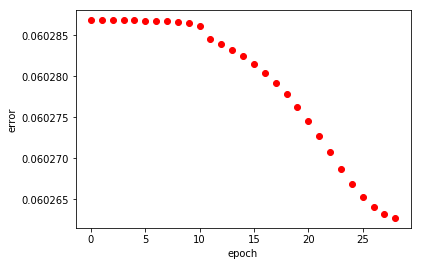

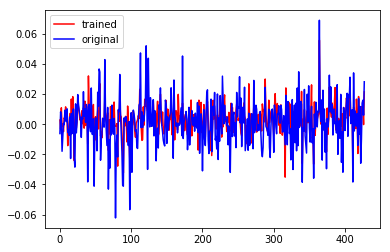

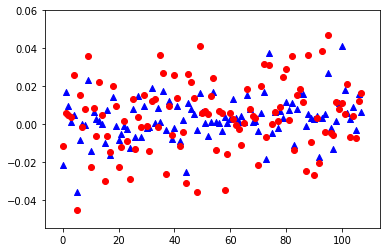

[[['gaussmf', {'sigma': 1.8793827566891141, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.948090381531994, 'mean': -0.032510943062842544}], ['gaussmf', {'sigma': 6.72610254090406, 'mean': 0.067042467}]]]
current error:  0.06028681547951471
current error:  0.06028680883658082
current error:  0.060286801679361054
current error:  0.060286794014447906
current error:  0.0602867849991652
current error:  0.06028677438250794
current error:  0.060286761864236066
current error:  0.0602867470842382
current error:  0.060286729609183055
current error:  0.06028670891562596
current error:  0.06028668436842324
current error:  0.06028665519288888
current error:  0.06028662043852707
current error:  0.06028657893130896
current error:  0.06028652921024602
current error:  0.06028646944220035
current error:  0.06028639730624453
current error:  0.0602863098349386
current error:  0.060286203193952795
current error:  0.06028607237234985
current error:  0.06028591074170837
current error:  0.060285709419973965

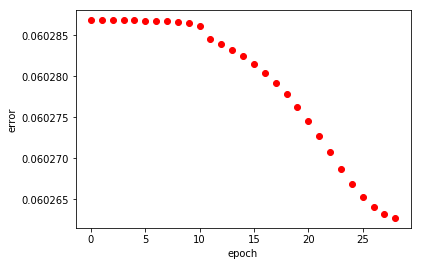

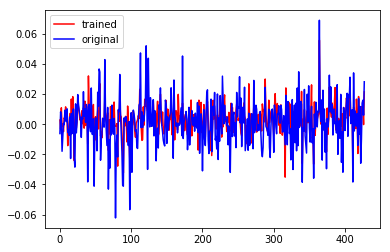

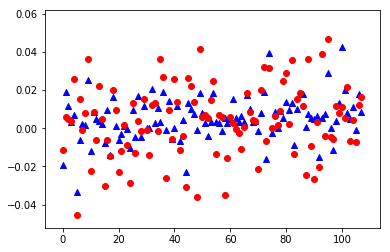

[[['gaussmf', {'sigma': 4.972876439346789, 'mean': -0.048816774}], ['gaussmf', {'sigma': 3.4309472723180647, 'mean': 0.053241548503068746}], ['gaussmf', {'sigma': 4.343954361259478, 'mean': 0.067042467}]]]
current error:  0.06028684126773391
current error:  0.060286840804851465
current error:  0.06028684012557687
current error:  0.06028683918861164
current error:  0.06028683781066761
current error:  0.06028683580563607
current error:  0.06028683290415801
current error:  0.06028682870676189
current error:  0.060286822601943665
current error:  0.06028681361446477
current error:  0.06028680010345108
current error:  0.06028677910373484
current error:  0.060286744701154193
current error:  0.06028668325658076
current error:  0.06028655480708556
current error:  0.060286164866509985
current error:  0.06026100072173717
current error:  0.060258835997946965
current error:  0.0602564844804076
current error:  0.06025396648209315
current error:  0.06025133933674522
current error:  0.0602487249209169

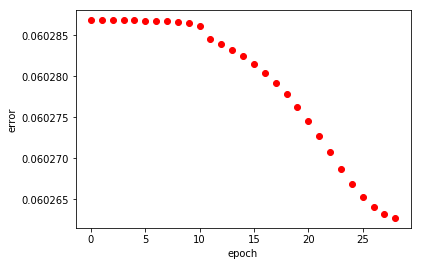

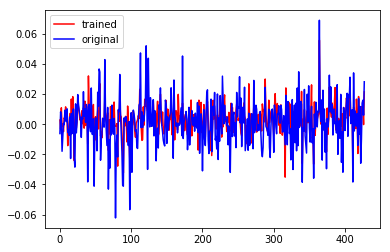

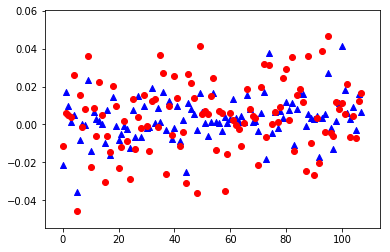

[[['gaussmf', {'sigma': 5.465810578887144, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.775294609672414, 'mean': -0.03207609770076866}], ['gaussmf', {'sigma': 8.833198243829054, 'mean': 0.067042467}]]]
current error:  0.06028684118008701
current error:  0.060286841076085396
current error:  0.06028684096260645
current error:  0.06028684083904222
current error:  0.060286840690616565
current error:  0.06028684051086125
current error:  0.06028684029109958
current error:  0.06028684001960149
current error:  0.060286839680445105
current error:  0.060286839252028594
current error:  0.06028683870515984
current error:  0.06028683800069764
current error:  0.06028683708674134
current error:  0.0602868358954324
current error:  0.06028683433947391
current error:  0.06028683230851111
current error:  0.06028682966543317
current error:  0.06028682624247103
current error:  0.06028682183663869
current error:  0.06028681620364155
current error:  0.060286809049001876
current error:  0.06028680001482093

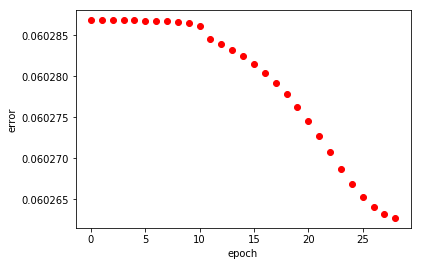

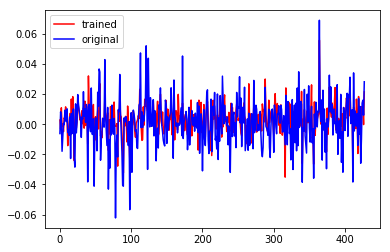

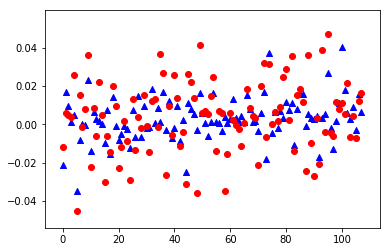

[[['gaussmf', {'sigma': 5.373895219606263, 'mean': -0.048816774}], ['gaussmf', {'sigma': 3.7379154237919328, 'mean': -0.003457357592391644}], ['gaussmf', {'sigma': 3.6236924866441362, 'mean': 0.067042467}]]]
current error:  0.06028684114825686
current error:  0.06028684003197756
current error:  0.06028683793055399
current error:  0.060286834154570174
current error:  0.060286826418377695
current error:  0.0602868070035053
current error:  0.06028666207135907
current error:  0.06028660039242185
current error:  0.06028653166553393
current error:  0.06028645108897897
current error:  0.06028635348394534
current error:  0.060286231940323926
current error:  0.060286076554756034
current error:  0.06028587273836656
current error:  0.060285598954906455
current error:  0.0602852242112593
current error:  0.06028470654552475
current error:  0.060283994571495594
current error:  0.06028303280544821
current error:  0.06028176771601853
current error:  0.06028015075157014
current error:  0.06027813938743

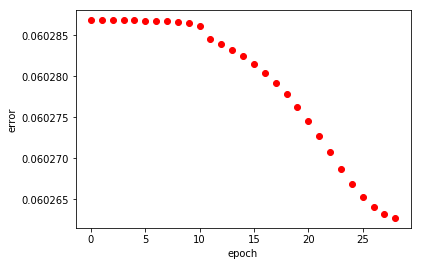

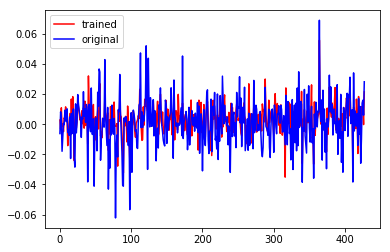

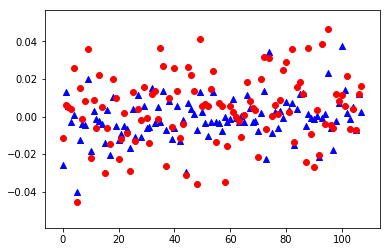

[[['gaussmf', {'sigma': 6.191439548254662, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.024758201323728, 'mean': 0.03658024338830144}], ['gaussmf', {'sigma': 7.896073327229201, 'mean': 0.067042467}]]]
current error:  0.06028684143141982
current error:  0.06028684104497827
current error:  0.060286840378984914
current error:  0.06028683944203915
current error:  0.060286838161875536
current error:  0.06028683653927109
current error:  0.060286834579132156
current error:  0.06028683227967817
current error:  0.06028682962952023
current error:  0.0602868266077795
current error:  0.06028682318470188
current error:  0.06028681932194408
current error:  0.060286814972383924
current error:  0.060286810079456105
current error:  0.0602868045760406
current error:  0.06028679838287626
current error:  0.06028679140645229
current error:  0.06028678353627112
current error:  0.06028677464131689
current error:  0.06028676456550582
current error:  0.06028675312177996
current error:  0.06028674008438077
c

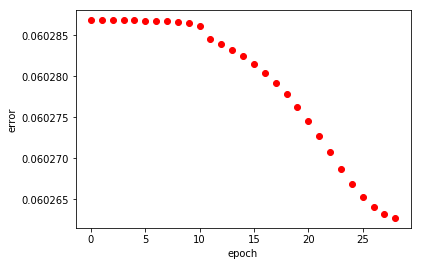

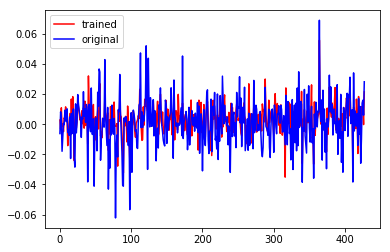

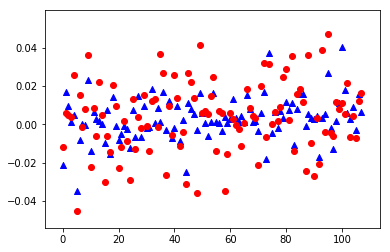

[[['gaussmf', {'sigma': 5.721863166469599, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.904163120742875, 'mean': 0.050800305253146015}], ['gaussmf', {'sigma': 3.441653548429791, 'mean': 0.067042467}]]]
current error:  0.060286841687605855
current error:  0.06028684138553925
current error:  0.060286840928526056
current error:  0.06028684030886612
current error:  0.060286839429989775
current error:  0.060286838211006534
current error:  0.060286836544802096
current error:  0.06028683428800364
current error:  0.060286831246150516
current error:  0.06028682715118944
current error:  0.06028682162626848
current error:  0.06028681412870549
current error:  0.06028680385376628
current error:  0.06028678956437465
current error:  0.06028676927185636
current error:  0.060286739593104065
current error:  0.06028669433147562
current error:  0.06028662092663029
current error:  0.06028648978351383
current error:  0.060286210790124015
current error:  0.06028529422823008
current error:  0.0602638630121

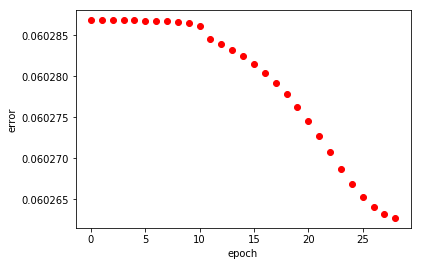

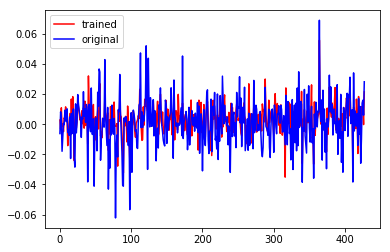

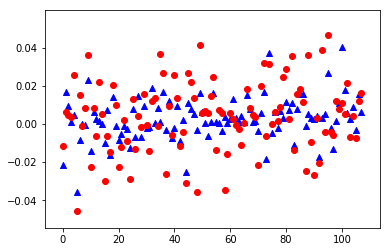

[[['gaussmf', {'sigma': 2.4850850643367997, 'mean': -0.048816774}], ['gaussmf', {'sigma': 3.677822880403144, 'mean': -0.038723057316132944}], ['gaussmf', {'sigma': 4.2327942622468555, 'mean': 0.067042467}]]]
current error:  0.060286833817281255
current error:  0.06028683104779561
current error:  0.06028682787920265
current error:  0.06028682431693072
current error:  0.06028681994983244
current error:  0.06028681461358212
current error:  0.06028680811332553
current error:  0.0602868002177936
current error:  0.060286790652010105
current error:  0.06028677908816882
current error:  0.060286765134095366
current error:  0.06028674831852041
current error:  0.06028672807209535
current error:  0.0602867037027054
current error:  0.060286674363086726
current error:  0.0602866390079725
current error:  0.06028659633689008
current error:  0.06028654471710157
current error:  0.060286482078801856
current error:  0.06028640577113821
current error:  0.0602863123622398
current error:  0.06028619735826864

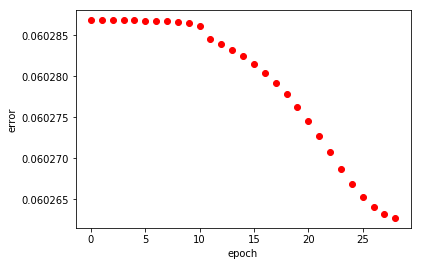

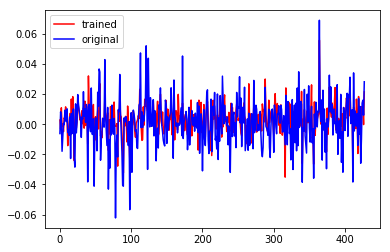

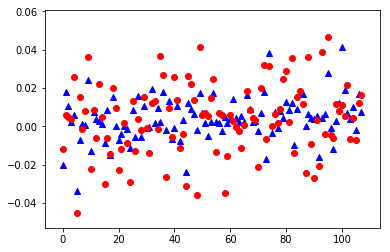

[[['gaussmf', {'sigma': 8.168103803177825, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.057164696940109, 'mean': -0.013118555132001358}], ['gaussmf', {'sigma': 5.423281809030321, 'mean': 0.067042467}]]]
current error:  0.06028684160909577
current error:  0.060286841496437434
current error:  0.06028684133537064
current error:  0.06028684112265803
current error:  0.06028684082550833
current error:  0.06028684041730495
current error:  0.06028683986304001
current error:  0.060286839116411396
current error:  0.06028683811581438
current error:  0.06028683677877126
current error:  0.060286834994179375
current error:  0.0602868326115118
current error:  0.06028682942579808
current error:  0.06028682515671967
current error:  0.06028681941929287
current error:  0.06028681168169693
current error:  0.06028680120151483
current error:  0.06028678692272231
current error:  0.06028676729869109
current error:  0.06028673997450618
current error:  0.06028670119581742
current error:  0.06028664465415771


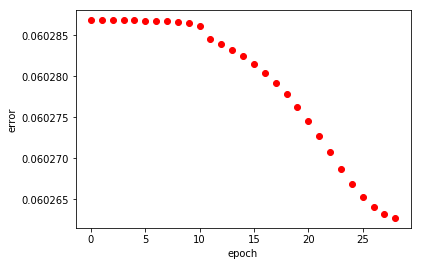

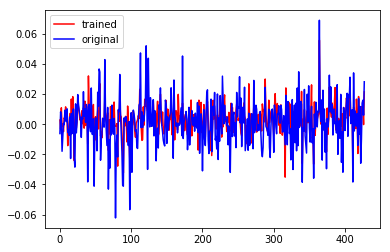

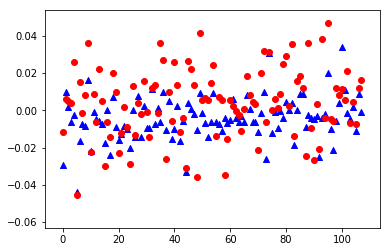

[[['gaussmf', {'sigma': 7.169059931227982, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.341997226055907, 'mean': 0.052689625283720405}], ['gaussmf', {'sigma': 8.731285859979472, 'mean': 0.067042467}]]]
current error:  0.06028684152891787
current error:  0.06028683438179329
current error:  0.06028682719718202
current error:  0.06028682213810826
current error:  0.06028681671871641
current error:  0.06028681062153385
current error:  0.060286803520705694
current error:  0.060286794964580795
current error:  0.060286784214854956
current error:  0.060286769860614466
current error:  0.060286748534830216
current error:  0.060286707848325655
current error:  0.06028634689376018
current error:  0.0602862360903331
current error:  0.06028610164796519
current error:  0.06028592883018723
current error:  0.060285694392628784
current error:  0.06028535526468509
current error:  0.06028481715494895
current error:  0.060283809724936625
current error:  0.06028086910959103
current error:  0.06025189307330

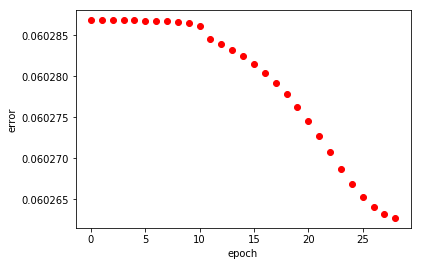

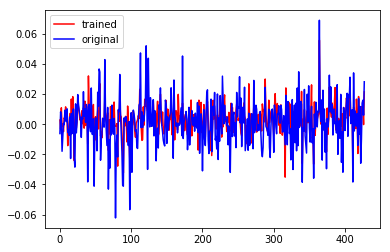

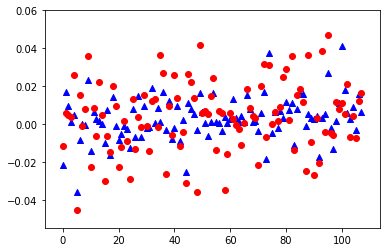

[[['gaussmf', {'sigma': 3.984085882630474, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.30768167598533, 'mean': -0.0462078176046242}], ['gaussmf', {'sigma': 4.225717412381476, 'mean': 0.067042467}]]]
current error:  0.06028684043954218
current error:  0.060286771767272505
current error:  0.06028676455631613
current error:  0.060286757281927006
current error:  0.060286749187339284
current error:  0.06028674016992495
current error:  0.060286730112528074
current error:  0.0602867188810639
current error:  0.06028670632165044
current error:  0.06028669225716365
current error:  0.06028667648308289
current error:  0.06028665876245767
current error:  0.06028663881977883
current error:  0.0602866163334739
current error:  0.060286590926677514
current error:  0.06028656215579747
current error:  0.06028652949626771
current error:  0.0602864923246657
current error:  0.060286449896089125
current error:  0.06028640131527187
current error:  0.06028634549934765
current error:  0.06028628112930106
cu

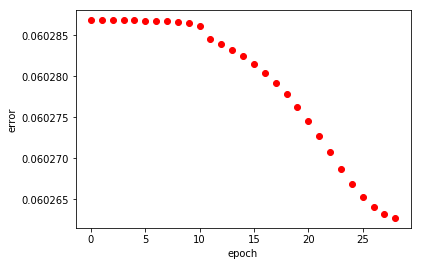

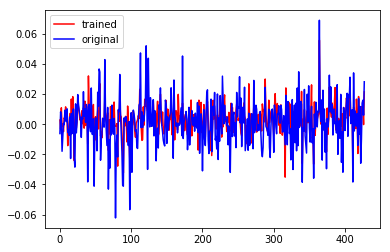

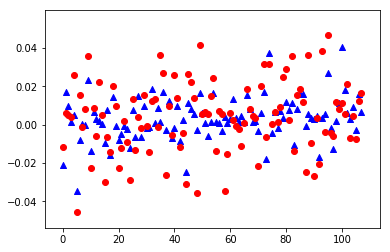

[[['gaussmf', {'sigma': 4.739726225928026, 'mean': -0.048816774}], ['gaussmf', {'sigma': 2.1414756291634025, 'mean': 0.019752211248498665}], ['gaussmf', {'sigma': 4.084278915682415, 'mean': 0.067042467}]]]
current error:  0.06028684259468737
current error:  0.060286843589216536
current error:  0.06028684423723444
current error:  0.06028684438354994
current error:  0.060286843951445374
current error:  0.060286842884000574
current error:  0.06028684112882332
current error:  0.06028683834321965
current error:  0.06028683415928656
current error:  0.060286828074344934
current error:  0.06028681938931721
current error:  0.060286807110042424
current error:  0.060286789781899074
current error:  0.06028676519710621
current error:  0.06028672984025432
current error:  0.06028667774223186
current error:  0.060286597816407
current error:  0.06028646653005814
current error:  0.06028622151641392
current error:  0.060285600400120966
current error:  0.06027327984149809
current error:  0.060271670657615

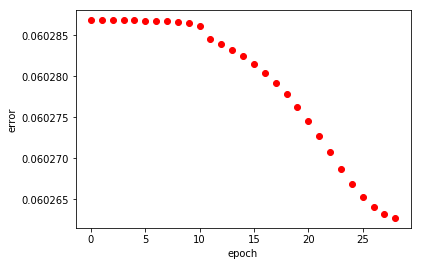

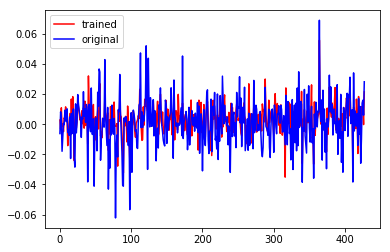

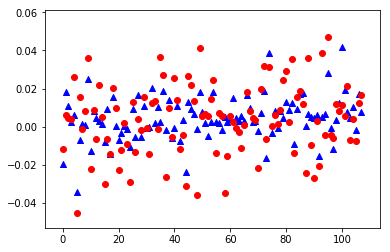

[[['gaussmf', {'sigma': 5.835594130241462, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.070655390332132, 'mean': -0.04150249000718219}], ['gaussmf', {'sigma': 5.81823739781366, 'mean': 0.067042467}]]]
current error:  0.060286841164090055
current error:  0.06028684032733917
current error:  0.06028683932201212
current error:  0.06028683818459574
current error:  0.060286836800853796
current error:  0.060286835141155334
current error:  0.060286833170787424
current error:  0.06028683084967123
current error:  0.060286828131815656
current error:  0.06028682496456382
current error:  0.06028682128761935
current error:  0.06028681703181947
current error:  0.060286812117601035
current error:  0.060286806453077504
current error:  0.06028679993161328
current error:  0.06028679242874015
current error:  0.06028678379820793
current error:  0.06028677386687388
current error:  0.06028676242803126
current error:  0.06028674923261891
current error:  0.060286733977528706
current error:  0.06028671628992

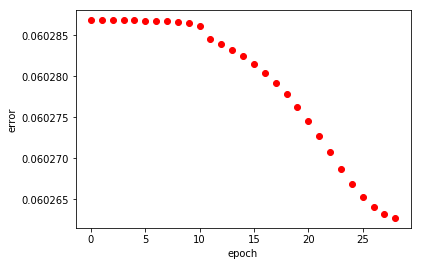

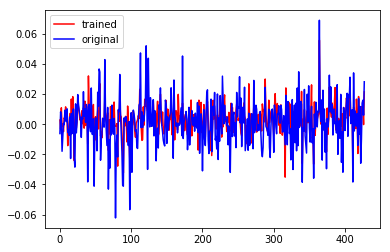

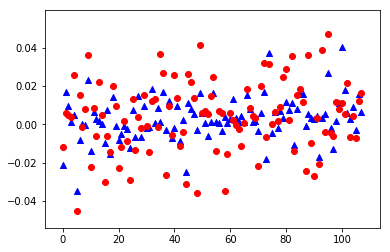

[[['gaussmf', {'sigma': 4.9715262772466415, 'mean': -0.048816774}], ['gaussmf', {'sigma': 3.509759527193572, 'mean': -0.036520215909018536}], ['gaussmf', {'sigma': 4.529092090454891, 'mean': 0.067042467}]]]
current error:  0.060286840030081876
current error:  0.06028683842282874
current error:  0.060286836629493995
current error:  0.06028683463887381
current error:  0.06028683222421247
current error:  0.06028682931262085
current error:  0.060286825820989765
current error:  0.06028682165371453
current error:  0.06028681670022783
current error:  0.060286810832079846
current error:  0.06028680389934852
current error:  0.060286795726145266
current error:  0.06028678610492086
current error:  0.060286774789195446
current error:  0.06028676148419505
current error:  0.06028674583471509
current error:  0.060286727409273246
current error:  0.060286705679270414
current error:  0.060286679991382174
current error:  0.060286649530685577
current error:  0.06028661327100122
current error:  0.060286569

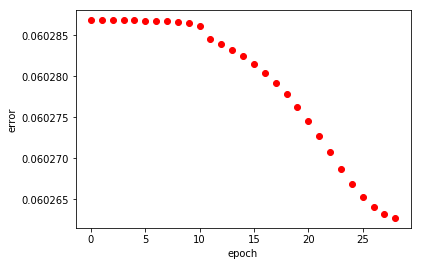

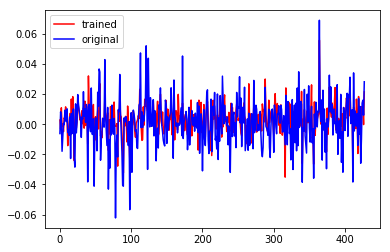

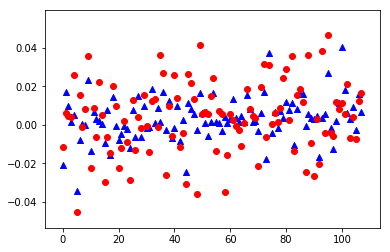

[[['gaussmf', {'sigma': 6.763085876966493, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.390940020412394, 'mean': 0.016507549862126887}], ['gaussmf', {'sigma': 6.166113938588014, 'mean': 0.067042467}]]]
current error:  0.06028684150358637
current error:  0.06028684080626522
current error:  0.06028683889921953
current error:  0.060286831836853905
current error:  0.060286793359745766
current error:  0.060286768578595225
current error:  0.06028661536459941
current error:  0.06028657834359943
current error:  0.06028653842634277
current error:  0.0602864934633312
current error:  0.06028644127691334
current error:  0.060286379173580595
current error:  0.06028630349233516
current error:  0.06028620895039412
current error:  0.060286087514889584
current error:  0.0602859262463052
current error:  0.0602857027288359
current error:  0.06028537400291104
current error:  0.06028484392296656
current error:  0.06028382867878899
current error:  0.06028066569672083
current error:  0.060262272526760655


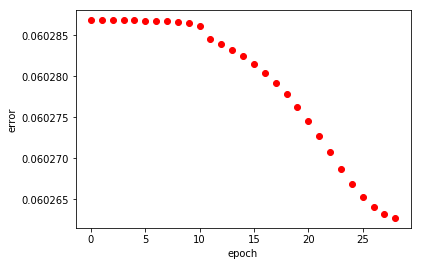

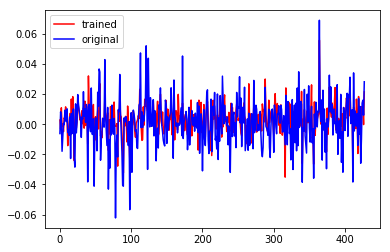

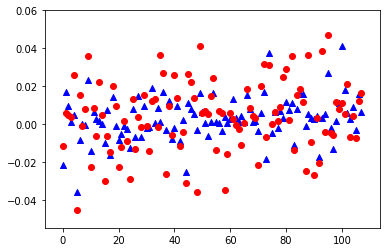

Iteration: 1
Avg Fitness: 0.4265901922499314
Best Fitness: 0.4278316214802096
(0.9854581521324484, 8.698634317540247)
0:03:36.713884


In [212]:
start=datetime.now()
ANFISGA()
print(datetime.now()-start)

In [28]:
'''
    ==============================================================
    Ant Colony Optimization algorithm for continuous domains ACO_R
    ==============================================================
    author: Andreas Tsichritzis <tsadreas@gmail.com>
'''

import os
import sys
import shutil
import math

import multiprocessing
#import datetime

from scipy.stats import norm

from collections import defaultdict
from operator import itemgetter




def svm_evaluator(x):
    '''Evaluator function, returns fitness and responses values'''
    # give the normalized candidates values inside the real design space
    #x= [10*i-5 for i in x]
    #print(x)
    #f = (sum([math.pow(i,4)-16*math.pow(i,2)+5*i for i in x])/2)
    
    x_train, x_test, y_train, y_test = GetData()
    svr_model = CreateSVRModel(x_train, y_train, C=x[0], epsilon=x[1])
    y_pred = svr_model.predict(x_test)
    y_true = y_test
    var = explained_variance_score(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    f = var
    print('var : ' + str(var))
    print('r2 : ' + str(r2))
    print('rmse : ' + str(rmse))
    print('c : ' + str(x[0]))
    print('epsilon : ' + str(x[1]))
    # calculate values for other responses
    res = {'r1':f-5,'r2':2*f}
    fitness = dict(Obj=f,**res)
    return fitness

def anfis_evaluator(x):
    '''Evaluator function, returns fitness and responses values'''
    # give the normalized candidates values inside the real design space
    #x= [10*i-5 for i in x]
    #print(x)
    #f = (sum([math.pow(i,4)-16*math.pow(i,2)+5*i for i in x])/2)

    x_train, x_test, y_train, y_test = GetData()
    anf = CreateANFISModel(x_train, y_train, sigma_lb=x[0], sigma_ub=x[1])
    y_pred = anfis.anfis.predict(anf, x_test)
    y_true = y_test
    var = explained_variance_score(y_true, y_pred)
    f = var
    #print('f : ' + str(f))
    # calculate values for other responses
    res = {'r1':f-5,'r2':2*f}
    fitness = dict(Obj=f,**res)
    return fitness

def mp_evaluator(x, func):
    '''Multiprocessing evaluation'''
    # ste number of cpus
    
    nprocs = 2
    # create pool
    pool = multiprocessing.Pool(processes=nprocs)
    results = [pool.apply_async(func,[c]) for c in x]
    #print(results)
    pool.close()
    pool.join()
    f = [r.get()['Obj'] for r in results]
    for r in results:
        del r.get()['Obj']
    # maximization or minimization problem
    
    maximize = False
    res = (f, [r.get() for r in results], maximize)
    #print(len(res))
    #print(np.array(res))
    return res


def initialize(ants,var,ul_bound):
    '''Create initial solution matrix'''   
    X = []
    for i in range(0, var):
        X.append(np.random.uniform(ul_bound[i][0], ul_bound[i][1], size=(ants, 1)))
    #X = np.random.uniform(low=0,high=1, size=(ants,var))
    return np.hstack(X)


def init_observer(filename,matrix,parameters,responses):
    '''Initial population observer'''
    p = []
    r = []
    f = []
    res = ['{0:>10}'.format(i)[:10] for i in responses]
    par = ['{0:>10}'.format(i)[:10] for i in parameters]
    for i in range(len(matrix)):
        p.append(matrix[i][0:len(parameters)])
        r.append(matrix[i][len(parameters):-1])
        f.append(matrix[i][-1])
    r = np.array(r)
    p = np.array(p)

    for i in range(len(r)):
        r[i] = ['{0:>10}'.format(r[i][j])[:10] for j in range(len(responses))]

    for i in range(len(p)):
        p[i] = ['{0:>10}'.format(p[i][j])[:10] for j in range(len(parameters))]

    f = ['{0:>10}'.format(i)[:10] for i in f]

    iteration = 0

    filename.write('{0:>10}, {1}, {2:>10}, {3}\n'.format('Iteration',', '.join(map(str, par)),'Fitness',', '.join(map(str, res))))

    for i in range(len(matrix)):
        filename.write('{0:>10}, {1}, {2:>10}, {3}\n'.format(iteration,', '.join(map(str, p[i])),f[i],', '.join(map(str, r[i]))))



def iter_observer(filename,matrix,parameters,responses,iteration):
    '''Iterations observer'''
    p = []
    r = []
    f = []
    for i in range(len(matrix)):
        p.append(matrix[i][0:len(parameters)])
        r.append(matrix[i][len(parameters):-1])
        f.append(matrix[i][-1])
    r = np.array(r)
    p = np.array(p)

    for i in range(len(r)):
        r[i] = ['{0:>10}'.format(r[i][j])[:10] for j in range(len(responses))]

    for i in range(len(p)):
        p[i] = ['{0:>10}'.format(p[i][j])[:10] for j in range(len(parameters))]

    f = ['{0:>10}'.format(i)[:10] for i in f]

    for i in range(len(matrix)):
        filename.write('{0:>10}, {1}, {2:>10}, {3}\n'.format(iteration,', '.join(map(str, p[i])),f[i],', '.join(map(str, r[i]))))




def formatTD(td):
    """ Format time output for report"""
    days = td.days
    hours = td.seconds // 3600
    minutes = (td.seconds % 3600) // 60
    seconds = td.seconds % 60
    return '%s days %s h %s m %s s' % (days, hours, minutes, seconds)

def evolve(display, func, var_names, ul_bound, nAnts = 8, pheromone_evaporation = 0.65, max_iterations = 300):
    '''Executes the optimization'''

    #start_time = time()
    start_time = datetime.now()

    # number of variables
    parameters_v = var_names
    response_v = ['r1','r2']

    # create output file
    projdir = os.getcwd()
    ind_file_name = '{0}/results.csv'.format(projdir)
    ind_file = open(ind_file_name, 'w')

    # number of variables
    nVar = len(parameters_v)
    # size of solution archive
    nSize = 8
    # number of ants
    nAnts = nAnts

    # parameter q
    q = 0.3

    # standard deviation
    qk = q*nSize

    # parameter xi (like pheromone evaporation)
    xi = pheromone_evaporation

    # maximum iterations
    maxiter = max_iterations
    # tolerance
    errormin = 0.01

    # bounds of variables
    #Up = [1]*nVar
    #Lo = [0]*nVar
    Up = [np.max(ul_bound)]*nVar
    Lo = [np.min(ul_bound)]*nVar

    # initilize matrices
    S = np.zeros((nSize,nVar))
    S_f = np.zeros((nSize,1))

    plt.figure()


    # initialize the solution table with uniform random distribution and sort it
    print('-----------------------------------------')
    print('Starting initilization of solution matrix')
    print('-----------------------------------------')
    
    
    Srand = initialize(nSize, nVar, ul_bound)
    #print(Srand)
    f,S_r,maximize = mp_evaluator(Srand, func)

    S_responses = []

    for i in range(len(S_r)):
        S_f[i] = f[i]
        k = S_r[i]
        row = []
        for r in response_v:
            row.append(k[r])
        S_responses.append(row)

    # add responses and "fitness" column to solution
    S = np.hstack((Srand,S_responses,S_f))
    # sort according to fitness (last column)
    S = sorted(S, key=lambda row: row[-1],reverse = maximize)
    S = np.array(S)

    init_observer(ind_file,S,parameters_v,response_v)

    # initilize weight array with pdf function
    w = np.zeros((nSize))
    for i in range(nSize):
        w[i] = 1/(qk*2*math.pi)*math.exp(-math.pow(i,2)/(2*math.pow(q,2)*math.pow(nSize,2)))


    if display:
        x = []
        y = []
        for i in S:
            x.append(i[0])
            y.append(i[1])

        plt.scatter(x,y)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.pause(2)
        plt.cla()

    # initialize variables
    iterations = 1
    best_par = []
    best_obj = []
    best_sol = []
    best_res = []
    worst_obj = []
    best_par.append(S[0][:nVar])
    best_obj.append(S[0][-1])
    best_sol.append(S[0][:])
    best_res.append(S[0][nVar:-1])
    worst_obj.append(S[-1][-1])

    stop = 0

    # iterations
    while True:
        #print '-----------------------------------------'
        print('Iteration', iterations)
        #print '-----------------------------------------'
        # choose Gaussian function to compose Gaussian kernel
        p = w/sum(w)

        # find best and index of best
        max_prospect = np.amax(p)
        ix_prospect = np.argmax(p)
        selection = ix_prospect

        # calculation of G_i
        # find standard deviation sigma
        sigma_s = np.zeros((nVar,1))
        sigma = np.zeros((nVar,1))
        for i in range(nVar):
            for j in range(nSize):
                sigma_s[i] = sigma_s[i] + abs(S[j][i] - S[selection][i])
            sigma[i] = xi / (nSize -1) * sigma_s[i]


        Stemp = np.zeros((nAnts,nVar))
        ffeval = np.zeros((nAnts,1))
        res = np.zeros((nAnts,len(response_v)))
        for k in range(nAnts):
            for i in range(nVar):
                Stemp[k][i] = sigma[i] * np.random.random_sample() + S[selection][i]
                if Stemp[k][i] > Up[i]:
                    Stemp[k][i] = Up[i]
                elif Stemp[k][i] < Lo[i]:
                    Stemp[k][i] = Lo[i]
        f,S_r,maximize = mp_evaluator(Stemp, func)

        S_f = np.zeros((nAnts,1))
        S_responses = []

        for i in range(len(S_r)):
            S_f[i] = f[i]
            k = S_r[i]
            row = []
            for r in response_v:
                row.append(k[r])
            S_responses.append(row)

        # add responses and "fitness" column to solution
        Ssample = np.hstack((Stemp,S_responses,S_f))

        # add new solutions in the solutions table
        Solution_temp = np.vstack((S,Ssample))

        # sort according to "fitness"
        Solution_temp = sorted(Solution_temp, key=lambda row: row[-1],reverse = maximize)
        Solution_temp = np.array(Solution_temp)

        # keep best solutions
        S = Solution_temp[:nSize][:]

        # keep best after each iteration
        best_par.append(S[0][:nVar])
        best_obj.append(S[0][-1])
        best_res.append(S[0][nVar:-1])
        best_sol.append(S[0][:])
        worst_obj.append(S[-1][-1])

        iter_observer(ind_file,S,parameters_v,response_v,iterations)

        if display:
            # plot new table
            x = []
            y = []
            for i in S:
                x.append(i[0])
                y.append(i[1])

            plt.scatter(x,y)
            plt.xlim(0,1)
            plt.ylim(0,1)
            plt.pause(2)

        if iterations > 1:
            diff = abs(best_obj[iterations]-best_obj[iterations-1])
            if diff <= errormin:
                stop += 1

        iterations += 1
        if iterations > maxiter or stop > 5:
            break
        else:
            if display:
                plt.cla()

    ind_file.close()

    total_time_s = datetime.now() - start_time
    
    #total_time = timedelta(seconds=total_time_s)
    #total_time = formatTD(total_time)

    # fix varibales values in output file
    #correct_par(ind_file_name,parameters_v)

    best_sol = sorted(best_sol, key=lambda row: row[-1],reverse = maximize)

    print("Best individual:", parameters_v)
    print(best_sol[0][0:len(parameters_v)])
    print("Fitness:")
    print(best_sol[0][-1])
    print("Responses:", response_v)
    print(best_sol[0][len(parameters_v):-1])


# Executes optimization run.
# If display = True plots ants in 2D design space
#evolve(display = False)

In [29]:
start=datetime.now()
ul_bound = [[1, 20], [0.01, 0.001]]
parameter_names = ['c', 'epsilon']
evolve(False, svm_evaluator, parameter_names, ul_bound, nAnts = 50)
print(datetime.now()-start)

-----------------------------------------
Starting initilization of solution matrix
-----------------------------------------


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4205341439004724
r2 : 0.41997106567980913
rmse : 0.013857039633060925
c : 12.43660237060024
epsilon : 0.002700106632996125
var : 0.4268635675477308
r2 : 0.4235476297526959
rmse : 0.013814251055166366
c : 12.552901474814046
epsilon : 0.00867204397218368


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42343228967231494
r2 : 0.4197337068797614
rmse : 0.013859874624286603
c : 1.2939415576660744
epsilon : 0.007636080833059413
var : 0.4221836385029264
r2 : 0.4203778987864176
rmse : 0.013852179107116827
c : 14.264638178617552
epsilon : 0.002891757943631585


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4261458500144061
r2 : 0.4202647776839795
rmse : 0.013853530761342837
c : 2.785762642030509
epsilon : 0.008918170433229098
var : 0.4272633997616798
r2 : 0.4256790385874307
rmse : 0.013788688592834187
c : 7.055639596212567
epsilon : 0.006424430628280731


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42766426562813575
r2 : 0.4270955161220571
rmse : 0.013771674217061297
c : 6.336554967748805
epsilon : 0.006203381840662173
var : 0.42527225311203576
r2 : 0.42382561380083605
rmse : 0.013810919813332307
c : 13.481408073421465
epsilon : 0.0042448643968269525
Iteration 1


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42555175857909655
r2 : 0.4236364804334668
var : 0.4235285961857608
r2 : 0.4213056417055824
rmse : 0.013841088771184808
c : 13.959694253745242
epsilon : 0.003816785346984904
rmse : 0.013813186393995987
c : 15.151104058697955
epsilon : 0.004248724178627116


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4268617796931814
r2 : 0.42608457481245476
rmse : 0.013783819538281868
c : 12.488832480650222
epsilon : 0.00468567799559042
var : 0.42750872579316435
r2 : 0.4265447333570702
rmse : 0.013778292579122645
c : 14.569465799442598
epsilon : 0.004731835691192591


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.423070934415298
r2 : 0.42033991628999834
rmse : 0.013852632964658709
c : 14.447651224653558
epsilon : 0.00362845140352609
var : 0.42510757013505496
r2 : 0.42378484376331726
rmse : 0.01381140843428811
c : 15.376190911498934
epsilon : 0.0036179931703212726


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42721873042559233
r2 : 0.42630521604399974
rmse : 0.013781169695513035
c : 14.222714083665721
epsilon : 0.004716683548171995
var : 0.425577855322947
r2 : 0.42328112812780583
rmse : 0.01381744394250378
c : 13.857678990787857
epsilon : 0.004253227510917272


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4225608279833377
r2 : 0.4208119269112558
rmse : 0.01384699179521081
c : 14.966711484893775
epsilon : 0.0031719815991752506
var : 0.42667427478443865
r2 : 0.4258172868267869
rmse : 0.01378702891403103
c : 13.181410801687727
epsilon : 0.0050638100206509395


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42331270142012023
r2 : 0.4203252122524931
rmse : 0.013852808661026865
c : 14.534245019939522
var : 0.4255004734132052
epsilon : 0.003645594189103967
r2 : 0.42392235453829075
rmse : 0.013809760325261601
c : 12.832103351256363
epsilon : 0.004288982532556534


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42562500004136805
r2 : 0.4233734136234246
rmse : 0.013816338377261796
c : 13.340683293153846
epsilon : 0.004265182060543958
var : 0.42259356959007266
r2 : 0.42051931468799664
rmse : 0.013850489180273356
c : 12.527970675691247
epsilon : 0.003181554805464221


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.425729075148065
r2 : 0.42352743792862857
rmse : 0.013814492994048702
c : 12.913226446256258
epsilon : 0.004575586340343735
var : 0.4211772126842813
r2 : 0.4194061936106558
rmse : 0.01386378546019627
c : 14.103131350367784
epsilon : 0.002926663588217762


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42629503263186286
r2 : 0.42422587317828997
rmse : 0.013806121864414564
c : 15.013388705418626
epsilon : 0.004618815159905656
var : 0.4237967688279689
r2 : 0.4215976556936599
rmse : 0.013837596166252202
c : 15.11218420800415
epsilon : 0.0038100403146468487


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42675203988893284
r2 : 0.42486988193218334
rmse : 0.013798398565854032
c : 14.326178073384296
epsilon : 0.00451654851682634
var : 0.42490395959495486
r2 : 0.42274696861736605
rmse : 0.01382384134965418
c : 14.399061620528556
epsilon : 0.004030202835367251


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42259054926474815
r2 : 0.42050048945448404
rmse : 0.013850714154618585
c : 15.065923266567788
epsilon : 0.003398397424841158
var : 0.42338682600780064
r2 : 0.4213226079236604
rmse : 0.01384088587249711
c : 13.983868368479472
epsilon : 0.0030137166854371984


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4245714315140726
r2 : 0.42305074917017493
rmse : 0.013820203459013736
c : 12.989640476000863
epsilon : 0.003188115131367334
var : 0.4226059859099791
r2 : 0.4204432623513098
rmse : 0.013851398034989299
c : 13.174305236015652
epsilon : 0.0031113293468100975


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4258784035700398
r2 : 0.4233356584721494
rmse : 0.013816790688531711
c : 14.31754973906185
epsilon : 0.0044620726548328625
var : 0.4218080541198185
r2 : 0.4204068574972045
rmse : 0.013851833065913251
c : 15.569940605252429
epsilon : 0.003091151208591288


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4256905500582794
r2 : 0.4248848203132547
rmse : 0.0137982193654714
c : 12.459313137729286
epsilon : 0.003514162339888878
var : 0.425727170326492
r2 : 0.42361031408880023
rmse : 0.01381349994306848
c : 13.303092980094979
epsilon : 0.00463986088829667


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4278411800389039
r2 : 0.42694047008084757
rmse : 0.013773537615918987
var : 0.42297255671707346
c : 14.72376532921536
epsilon : 0.0047864365229492705
r2 : 0.4182164663722251
rmse : 0.013877982719878624
c : 13.728089270073253
epsilon : 0.002895344590790973


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42251089188389057
var : 0.425132354151288
r2 : 0.4197105603234943
r2 : 0.423806244723831
rmse : 0.013860151053550622
rmse : 0.013811151950101717
c : 14.563735617165822
c : 14.29477141818116
epsilon : 0.0029117317761460284
epsilon : 0.0036212357689113122


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42678057118108004
r2 : 0.4239033278565367
rmse : 0.013809988377632108
var : 0.4256007815199606
c : 14.909115666543519
epsilon : 0.004860678882133427
r2 : 0.42383317097399764
rmse : 0.013810829240185282
c : 14.939646553170846
epsilon : 0.004274286675982417


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42674738991116934
r2 : 0.4252444423012447
rmse : 0.013793904647994636
c : 14.399730825132808
epsilon : 0.004975252361834739
var : 0.42217109955628884
r2 : 0.4211526203616367
rmse : 0.013842918616233116
c : 15.006885687099574
epsilon : 0.003009254476657305


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42389309549140297
r2 : 0.42220355144162713
rmse : 0.013830346595447988
c : 12.615664754164394
epsilon : 0.003668963317161242
var : 0.4266950137842681
r2 : 0.42515967532051446
rmse : 0.013794921797394132
c : 14.784380155912366
epsilon : 0.004440498344860358


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4260696964634718
r2 : 0.42492381065591844
rmse : 0.013797751627495601
c : 14.506987416684463
epsilon : 0.004721132842556676
var : 0.4227785142411876
r2 : 0.4209336905510652
rmse : 0.013845536181028786
c : 14.488969620565564
epsilon : 0.0034421697244188805


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42702868893652834
r2 : 0.4254813249850973
rmse : 0.013791061809979153
c : 14.173176973640793
epsilon : 0.004852369305032257
var : 0.4249149240779566
r2 : 0.42320567676905074
rmse : 0.013818347771799447
c : 12.908402618461727
epsilon : 0.003980079553613908


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42124209720095374
r2 : 0.42000180381930563
rmse : 0.013856672457188074
c : 13.98559670946007
epsilon : 0.0027268904409665264
var : 0.4237068126369523
r2 : 0.4220146062877992
rmse : 0.01383260774067719
c : 12.806599429837412
epsilon : 0.0037805582028104176


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221803944398528
r2 : 0.42116725610626304
rmse : 0.013842743610947136
c : 13.74823714613115
epsilon : 0.003189459668913868
var : 0.42258675291701686
r2 : 0.420468641872741
rmse : 0.013851094746562865
c : 13.364581446435592
epsilon : 0.0032413062559374355


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42670887951487213
r2 : 0.42489543172164845
rmse : 0.013798092069912737
c : 12.596591539507374
epsilon : 0.004530152415557516
var : 0.42483913293231634
r2 : 0.42261114406829037
rmse : 0.013825467591943455
c : 15.618030584060243
epsilon : 0.00401224214177878


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4270695019643318
r2 : 0.4262532031982408
rmse : 0.013781794401914231
c : 12.895381420287725
epsilon : 0.004649465334634604
var : 0.4249478601035357
r2 : 0.4217150924333428
rmse : 0.013836191326966129
c : 13.003315305797306
epsilon : 0.00402828790548962
Iteration 2


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.421126058543844
var : 0.42253940287710934
r2 : 0.419968289720128
rmse : 0.013857072792214738
r2 : 0.4217187820302143
rmse : 0.01383614718778059
c : 13.637636957372303
epsilon : 0.00274308850750298
c : 13.568013625417137
epsilon : 0.002750027588787768


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42155141662967544
r2 : 0.42041908397082217
rmse : 0.013851686963455956
c : 13.071155275250083
epsilon : 0.00279015658357344
var : 0.42362770728792454
r2 : 0.4219567267819506
rmse : 0.013833300322589025
c : 13.371145388271865
epsilon : 0.002831682023642762


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4202983696350904
r2 : 0.41843944875119476
rmse : 0.01387532293149112
var : 0.42143301956628754
c : 13.532188519281718
r2 : 0.4194866567519312
epsilon : 0.0027773963166011773
rmse : 0.013862824752066115
c : 13.053518498580672
epsilon : 0.0027777915962698446


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42311881148995045
r2 : 0.42175581768185644
rmse : 0.013835704117077071
c : 12.449705111887743
epsilon : 0.0028241241901493953
var : 0.42280439696171523
r2 : 0.42202214547653893
rmse : 0.01383251752474636
c : 12.97270933095958
epsilon : 0.002716049783049652


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42357566986147077
r2 : 0.42269322888377237
rmse : 0.013824484804276197
c : 13.105763128028721
epsilon : 0.002797466022976483
var : 0.4232222179408254
r2 : 0.4227093346586728
rmse : 0.013824291964347375
c : 12.888665725683238
epsilon : 0.002790887705115906


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4203923247830289
r2 : 0.4192340527931868
rmse : 0.01386584055143789
c : 13.159452564574028
epsilon : 0.002805014219790674
var : 0.4231497377275021
r2 : 0.4218471920740384
rmse : 0.01383461091195697
c : 13.078236199039386
epsilon : 0.002804230369233103


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42279931332324605
r2 : 0.4212024726774485
rmse : 0.013842322503653182
c : 12.517469402018364
epsilon : 0.002700240000416119
var : 0.4236407337044116
r2 : 0.42208913752550514
rmse : 0.01383171585428646
c : 12.712833791204718
epsilon : 0.002839257960839969


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42086055967476765
r2 : 0.4196876130589152
rmse : 0.013860425097318559
c : 13.568480111173209
epsilon : 0.0027373142385396145
var : 0.42042462318407947
r2 : 0.41909498464431794
rmse : 0.013867500584507425
c : 12.541393733979358
epsilon : 0.0027367911674300756


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42313087942913885
r2 : 0.4218281477454666
rmse : 0.013834838765824161
c : 13.197635695045324
epsilon : 0.002800787855534344


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4235549489698197
r2 : 0.42255076830501637
rmse : 0.013826190416197807
c : 13.600112506936085
epsilon : 0.0028352284991014216


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4210110136465556
r2 : 0.41888953478059143
rmse : 0.013869952641353985
c : 12.541386655693417
epsilon : 0.0027690539490892686


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4231690410441923
r2 : 0.4218221144195431
rmse : 0.013834910950135186
c : 12.612647558750934
epsilon : 0.002851531042058547


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4206332002483465
r2 : 0.4191707222692562
rmse : 0.013866596541878705
c : 13.50168167643636


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


epsilon : 0.0027951281164967385
var : 0.422941647082403
r2 : 0.42162565865466106
rmse : 0.013837261193235768
c : 12.972364873849124
epsilon : 0.002764938545175022


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.423565612546549
r2 : 0.42236212086011116
rmse : 0.013828448677497173
c : 12.808967095906834
epsilon : 0.0028013173030102716


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4226909227839515
r2 : 0.4211825802228746
rmse : 0.013842560372158773
c : 12.730551984043853
epsilon : 0.0027874574675090663


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.422172957301143
r2 : 0.4211849939782515
rmse : 0.013842531509353145
c : 13.101950157341998
epsilon : 0.002815370793549298
var : 0.4235088027286691
r2 : 0.4222434237411852
rmse : 0.013829869388260528
c : 13.233311727764894
epsilon : 0.0028010268061668623


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4229328015620748
r2 : 0.4218364946870803
rmse : 0.013834738900180625
c : 13.269122320928465


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


epsilon : 0.002752168640032408
var : 0.42351005010827136
r2 : 0.422830314753316
rmse : 0.01382284334246378
c : 12.496470198054059
epsilon : 0.0028057756616518426


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4229696688355872
r2 : 0.4216568084410445
rmse : 0.01383688856818728
c : 13.580016398757984
epsilon : 0.002771307656668164
var : 0.42242250381436075
r2 : 0.42092033634988657
rmse : 0.013845695830283614
c : 12.679631055080453
epsilon : 0.0027833840870507805


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4213992345242257
r2 : 0.4204775953740314
rmse : 0.01385098774952815
c : 12.5557497421908
epsilon : 0.0027290401606229462
var : 0.4213027414269387
r2 : 0.4200864500952082
rmse : 0.013855661282907484
c : 13.67679318119868
epsilon : 0.002816135715993916


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4226008126239358
r2 : 0.4207791017469963
rmse : 0.013847384174958791
c : 13.199677380858814
epsilon : 0.0027026051564523444
var : 0.4220247510640315
r2 : 0.4209478640603104
rmse : 0.013845366734945762
c : 13.234376939207749
epsilon : 0.002724845639738593


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42063881445483386
r2 : 0.419618496988465
rmse : 0.013861250471390005
c : 12.89435546398034
epsilon : 0.002730344402945361
var : 0.42086034930244165
r2 : 0.4179649614435933
rmse : 0.01388098212060975
c : 12.865053921174324
epsilon : 0.0028283223502159243


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42040496985490106
r2 : 0.4189777171196105
rmse : 0.013868900232782044
c : 12.544759096052045
epsilon : 0.0027113036193975445
var : 0.42287117883807135
r2 : 0.4212119525115313
rmse : 0.013842209144964025
c : 13.546816278551544
epsilon : 0.0027524533904013824


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4238757579562493
r2 : 0.4230633856831759
rmse : 0.01382005211109475
c : 12.709602397704744
epsilon : 0.0028441478634066695
var : 0.4228151700519286
r2 : 0.4215613383378949
rmse : 0.013838030584455648
c : 12.438575110608788
epsilon : 0.00274516200338471


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42316430871762667
r2 : 0.42171480104217485
rmse : 0.013836194812915176
c : 13.465301884615394
epsilon : 0.0028682739436426746
var : 0.4235061103678498
r2 : 0.4221963748078362
rmse : 0.013830432486443651
c : 13.662270693057781
epsilon : 0.0028160848014417016


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4231669089017258
r2 : 0.4218189393688846
rmse : 0.013834948937131848
c : 12.92782248659679
epsilon : 0.0028524007369720205
var : 0.4228103118706522
r2 : 0.421572595113586
rmse : 0.013837895935464768
c : 12.497830816077176
epsilon : 0.0027687237321697483


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4211680252528345
r2 : 0.4192305288239746
rmse : 0.013865882618919047
c : 12.654267591074797
epsilon : 0.002742352037722706
var : 0.42089705397016997
r2 : 0.4198549239824725
rmse : 0.013858426891051524
c : 13.652699234736588
epsilon : 0.0028245317490117727


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42072684639091806
r2 : 0.4179778707703935
rmse : 0.013880828182172835
c : 13.325537144583276
epsilon : 0.0027842455139683226
var : 0.4235080322528634
r2 : 0.42241573336597704
rmse : 0.013827806930292005
c : 13.5142381922134
epsilon : 0.00280120964808799


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4235168960509349
r2 : 0.4224349103608339
rmse : 0.013827577372460502
c : 12.728218935932254
epsilon : 0.0027846079138431016
var : 0.42194782740454384
r2 : 0.4208427229277244
rmse : 0.013846623661027988
c : 12.733048489482911
epsilon : 0.002827084288572029
Iteration 3


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42103273872765734
var : 0.42048265424666353
r2 : 0.4193466001691346
rmse : 0.013864496946849734
c : 13.618097657061078
epsilon : 0.002791117831344501
r2 : 0.41807743638933526
rmse : 0.013879640845565299
c : 13.680169693097252
epsilon : 0.0027887827514480584


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42223196472933244
r2 : 0.4212675128062402
rmse : 0.013841544743132926
c : 13.574912009732383
epsilon : 0.002796377478524503
var : 0.4232659358333627
r2 : 0.42241372831684876
rmse : 0.01382783093147224
c : 13.574178537575989
epsilon : 0.002790115169205131


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4226651408501396
r2 : 0.4211471789466218
rmse : 0.013842983680782803
c : 13.86777909669286
epsilon : 0.002801054242813851
var : 0.4205646341002388
r2 : 0.4195418121589525
rmse : 0.013862166172971346
c : 13.894927289580476
epsilon : 0.002799207246144926


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4235074841142229
r2 : 0.42241529237582065
rmse : 0.013827812209110982
c : 13.562009392233364
epsilon : 0.0028003258336637676
var : 0.42331515815917176
r2 : 0.4221410433690672
rmse : 0.01383109468323093
c : 13.632712762428847
epsilon : 0.002784913967124546


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4206961839709892
r2 : 0.41911660792940986
rmse : 0.013867242484042426
c : 13.785968102235476
epsilon : 0.002802198701858483
var : 0.4221725080432318
r2 : 0.4212276917083252
rmse : 0.013842020935535822
c : 13.652084875833795
epsilon : 0.0027784541426073422


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4224096288836605
r2 : 0.4214052772880572
rmse : 0.013839897188541393
c : 13.642616883527193
epsilon : 0.002784087274599719
var : 0.42050307469674086
r2 : 0.4193680750082769
rmse : 0.013864240562753182
c : 13.621577646526637
epsilon : 0.0027924242688528284


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4235063863245322
r2 : 0.4224142306791384
rmse : 0.013827824918013596
c : 13.762349432440685
epsilon : 0.0027970293317497374
var : 0.42237533165450547
r2 : 0.42142589517323215
rmse : 0.013839650598016128
c : 13.604338220489618
epsilon : 0.0027963275208582774


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4231345569716367
r2 : 0.42191273085655423
rmse : 0.013833826751402432
c : 13.597545679775864
epsilon : 0.0027864666529759186
var : 0.4224610478543469
r2 : 0.4215205320064397
rmse : 0.013838518682279649
c : 13.62208200878515
epsilon : 0.0027964337528773434


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221304091417004
r2 : 0.420718443762659
rmse : 0.013848109228582858
c : 13.738487117941935
epsilon : 0.002786787499664294
var : 0.4214728919502635
r2 : 0.4202746031576218
rmse : 0.013853413364578893
c : 13.815882478938876
epsilon : 0.0027910974001141868


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42336357672856606
r2 : 0.42252199916117084
rmse : 0.01382653482977125
c : 13.589180015733104
epsilon : 0.002789972242157258
var : 0.4220793920708329
r2 : 0.4211167662251296
rmse : 0.01384334732872776
c : 13.707052311225503
epsilon : 0.0027832111804814174


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4220584976533456
r2 : 0.42109700804223194
rmse : 0.013843583574172962
c : 13.684214081625822
epsilon : 0.002779524890073674
var : 0.42096932545721544
r2 : 0.41987927183676244
rmse : 0.013858136078879757
c : 13.853776206498345
epsilon : 0.0027953311818174555


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4217606890758472
r2 : 0.4206600544895538
rmse : 0.013848807128117742
var : 0.42238942656920786
r2 : 0.42126655729988227
rmse : 0.013841556169550864
c : 13.76965379571649
c : 13.607049480673087
epsilon : 0.002803638924690693
epsilon : 0.0027826683681055984


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4210939080498439
r2 : 0.4200183905787467
rmse : 0.013856474319558115
c : 13.739074809793125
epsilon : 0.00279184600954568
var : 0.42327454006981435
r2 : 0.42242316956168
rmse : 0.013827717915913166
c : 13.57535002923239
epsilon : 0.002790253864791973


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.421048324341168
r2 : 0.41809228919995334
rmse : 0.013879463714615863
c : 13.688155676150616
epsilon : 0.0027888717485866836
var : 0.42191400382784294
r2 : 0.42044799949552647
rmse : 0.013851341426032907
c : 13.707104619564555
epsilon : 0.002778514394178433


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4235075702422372
r2 : 0.4224153616310492
rmse : 0.013827811380099834
c : 13.554688718190073
epsilon : 0.002800092749880533
var : 0.4220313660357635
r2 : 0.42062204103529854
rmse : 0.013849261466166583
c : 13.718726465625862
epsilon : 0.0027849576006962404


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42253259575844004
r2 : 0.4214985458616277
rmse : 0.013838781658583628
c : 13.670044227086075
epsilon : 0.0028023103956510515
var : 0.4235020517211786
r2 : 0.42239043372521023
rmse : 0.013828109773303208
c : 13.669129147362689
epsilon : 0.0028016216758907763


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4225088519536031
r2 : 0.42078542169718214
rmse : 0.013847308629500076
c : 13.87999902631172
epsilon : 0.0027816146879277577
var : 0.42326112980553676
r2 : 0.42233573635902133
rmse : 0.013828764491752198
c : 13.722465273891597
epsilon : 0.002801047232928917


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4236330031916945
var : 0.42204656394650086
r2 : 0.4223997581817004
r2 : 0.42108414022717966
rmse : 0.013827998158004718
c : 13.872868260375949
epsilon : 0.0027921467160041008
rmse : 0.013843737430419757
c : 13.682016183990314
epsilon : 0.0027788867329551297


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4207500410812436
r2 : 0.4189707028159204
rmse : 0.013868983947630292
c : 13.556331733131739
epsilon : 0.0027844779777647113
var : 0.42189769433496105
r2 : 0.4208150471070782
rmse : 0.013846954496977173
c : 13.748129260094727
epsilon : 0.002783601962590171


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4220999410952806
r2 : 0.4211438320778266
rmse : 0.013843023700094674
c : 13.677231048446938
epsilon : 0.002779767169032718
var : 0.4216110306775517
r2 : 0.4200678698577084
rmse : 0.013855883246522012
c : 13.786517466910496
epsilon : 0.0027807975878627596


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42303758226980503
r2 : 0.42172508442310963
rmse : 0.01383607179100942
c : 13.813790943501301
epsilon : 0.0027835063613612303
var : 0.4234773807891147
r2 : 0.4226482778491022
rmse : 0.013825023004095376
c : 13.606907609517883
epsilon : 0.0027897603689571813


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4223627535194616
r2 : 0.4214405710318293
rmse : 0.013839475071630204
c : 13.63431481510649
epsilon : 0.002781586170160782
var : 0.4218404337061795
r2 : 0.42076477290578584
rmse : 0.013847555453086463
c : 13.72696415246307
epsilon : 0.0027791280559678736


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42071848822033875
r2 : 0.41893266175139066
rmse : 0.013869437954235952
c : 13.564466034237226
epsilon : 0.0027843087536203377
var : 0.42069823912401605
r2 : 0.41911870661422745
rmse : 0.013867217433405802
c : 13.786515268068237
epsilon : 0.0028023496236782475


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42245178744460243
var : 0.4227491816433595
r2 : 0.4215959270179226
rmse : 0.013837616844504215
r2 : 0.4189990750059588
c : 13.59687806726643
rmse : 0.013868645325934376
c : 13.778802017814895
epsilon : 0.0027934141814538994
epsilon : 0.002790196407698876


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4214819951997324
r2 : 0.41963873825861975
rmse : 0.013861008758171775
c : 13.762321292664621
epsilon : 0.0027885662753760927
var : 0.4230698861461619
r2 : 0.42146295703354364
rmse : 0.013839207326007135
c : 13.71785632671669
epsilon : 0.002789964148668132
Iteration 4


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221894253132893
var : 0.4235040077284965
r2 : 0.42226534403919336
r2 : 0.42078336795546634
rmse : 0.013829607030594366
rmse : 0.013847333178925487
c : 13.651634294497766
c : 13.798632969748471
epsilon : 0.0027788817579419284
epsilon : 0.002795424765385184


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42202055156283835
var : 0.4222903311914393
r2 : 0.4213303402665879
r2 : 0.42086783708626174
rmse : 0.01384079340056459
c : 13.586304012987895
rmse : 0.01384632344027144
c : 13.709593407988153
epsilon : 0.0027864922937539957
epsilon : 0.0027987648079691087


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42350672793479316
var : 0.42281681287816797
r2 : 0.4224145286182568
r2 : 0.4211518029692207
rmse : 0.013842928390046643
c : 13.867579971714694
rmse : 0.01382782135157315
c : 13.695579141549787
epsilon : 0.0027778358846114637
epsilon : 0.0027982418785175846


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4230367238963727
r2 : 0.42172391089312655
rmse : 0.013836085830211554
c : 13.809726242032715
epsilon : 0.0027833414683452458
var : 0.4234714236053848
r2 : 0.42233502367415254
rmse : 0.013828773022267923
c : 13.663699118665598
epsilon : 0.0027845010378331233


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4224839973272442
r2 : 0.4215441992149962
rmse : 0.013838235593184972
var : 0.4220313327299867
c : 13.62629691503055
r2 : 0.42058257412600086
epsilon : 0.002798943197180352
rmse : 0.013849733160187448
c : 13.698543540451329
epsilon : 0.0027806871161790876


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42105162404575913
r2 : 0.41996969237358883
rmse : 0.013857056037369687
var : 0.4216174276278759
c : 13.72940411665148
r2 : 0.4206133629161568
epsilon : 0.0027948216446029273
rmse : 0.013849365185240744
c : 13.885468946841327
epsilon : 0.0027778168921366356


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4226853163216735
r2 : 0.42176836131878426
rmse : 0.013835554049860147
c : 13.66920458914766
epsilon : 0.00279658160666008
var : 0.4214946991500813
r2 : 0.42029881566136496
rmse : 0.01385312406439716
c : 13.807076403546093
epsilon : 0.0027910162529644826


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4204653595152479
r2 : 0.41863701485164506
rmse : 0.013872965888622722
c : 13.545495129282658
epsilon : 0.0027801407002087603
var : 0.4221781916124603
r2 : 0.42101824319670833
rmse : 0.01384452531281499
c : 13.760916463676843
epsilon : 0.002784490468745909


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4224637859085115
r2 : 0.42155398403553357
rmse : 0.01383811855293379
c : 13.622503258947177
epsilon : 0.0027829659674440638
var : 0.42352067787287373
r2 : 0.42239140012618837
rmse : 0.013828098205364257
c : 13.673578143561283
epsilon : 0.0027856626490872093


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.421072466147164
r2 : 0.41999386280953577
rmse : 0.013856767315754403
c : 13.73425322506457
epsilon : 0.0027931258837726805
var : 0.42163415634796375
r2 : 0.4205243147628883
rmse : 0.013850429425363197
c : 13.774216413024384
epsilon : 0.002779772696618306


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4231222036407689
r2 : 0.4218193504636305
rmse : 0.01383494401871077
c : 13.725720403668571
epsilon : 0.0028001129330713016
var : 0.4222381790453056
r2 : 0.4205264083028917
rmse : 0.013850404405802418
c : 13.776709347737436
epsilon : 0.0027846944564259516


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4230663769418026
r2 : 0.4216066422285788
rmse : 0.013837488669692602
c : 13.825951504663166
epsilon : 0.002778169330797249
var : 0.4219371465575511
r2 : 0.4205336038144555
rmse : 0.013850318413053245
c : 13.69041605439243
epsilon : 0.002785629286427441


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.420986926122048
r2 : 0.41989831909508457
rmse : 0.01385790857307653
c : 13.716275124216113
epsilon : 0.0027950503820261315
var : 0.4230550832984248
r2 : 0.422173860747718
rmse : 0.013830701934524044
c : 13.575959831803933
epsilon : 0.002801450166556187


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42156959977382513
r2 : 0.42054388764519646
rmse : 0.013850195511222215
c : 13.771482844006982
epsilon : 0.002777624463972407
var : 0.4207625988588938
r2 : 0.4189859441216761
rmse : 0.01386880204388454
c : 13.556216050622105
epsilon : 0.002784651037210613


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4212601289712965
r2 : 0.42020175548798677
rmse : 0.013854283739746334
c : 13.773167809282162
epsilon : 0.002791332873921754
var : 0.42052665691108937
r2 : 0.4187094874340038
rmse : 0.013872101161228565
c : 13.552707096037606
epsilon : 0.002781233007850758


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42085888988200326
r2 : 0.4197580612217784
rmse : 0.013859583765009755
c : 13.690961222821084
epsilon : 0.0027941922738537153
var : 0.42309584527653055
r2 : 0.42163721152884015
rmse : 0.013837122994733156
c : 13.797185178788602
epsilon : 0.0027784536100838096


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4231218159193709
r2 : 0.42181895438688943
rmse : 0.013834948757453417
c : 13.741623943300961
epsilon : 0.0028000584487005375
var : 0.4235044351964027
r2 : 0.4224127817085559
rmse : 0.013827842262709418
c : 13.866810290539483
epsilon : 0.002792555212432134


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4206707809771789
r2 : 0.4188755586080838
rmse : 0.01387011943209073
c : 13.589416621472786
epsilon : 0.002784482003940446
var : 0.42075671792848146
r2 : 0.4193072046330101
rmse : 0.013864967270476796
c : 13.542411588277265
epsilon : 0.00279844002312745


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221890881841983
r2 : 0.4212460326212355
rmse : 0.01384180161153901
c : 13.651985300032969
epsilon : 0.002778919486738104
var : 0.4235046988702217
r2 : 0.422412893029691
rmse : 0.01382784093015641
c : 13.83409292267327
epsilon : 0.0027943465250197465


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42032000997407415
r2 : 0.4184645896948911
var : 0.42196192121912257
r2 : 0.4208118713101906
rmse : 0.013875023012177466
rmse : 0.013846992459854568
c : 13.549015885155706
c : 13.699335028156842
epsilon : 0.00278508180204924
epsilon : 0.0027782605252221764


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4213275589564386
r2 : 0.4202611699778388
rmse : 0.01385357386670225
var : 0.42197218438412454
r2 : 0.4209200268103698
rmse : 0.013845699530801602
c : 13.692865471892155
epsilon : 0.002778236588183572
c : 13.807546798129422
epsilon : 0.0027955431740848595


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4206550489529267
r2 : 0.4188556874891186
rmse : 0.013870356569283381
c : 13.565457413212323
epsilon : 0.0027834524361570754
var : 0.42227142328868095
r2 : 0.4212641701043499
rmse : 0.013841584716775318
c : 13.632288755976521
epsilon : 0.0027786433809156358


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42330683992774676
r2 : 0.42213188488774145
rmse : 0.013831204287243307
c : 13.631077992084125
epsilon : 0.0027846262408546046
var : 0.42306275568867246
r2 : 0.4217604021354324
rmse : 0.013835649270637733
c : 13.811715651273735
epsilon : 0.0027886144255110656


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4220887960173483
r2 : 0.42093296329636054
rmse : 0.013845544875394182
c : 13.729115150578513
epsilon : 0.002786277200710819
var : 0.42310408260433285
r2 : 0.4221548822570179
rmse : 0.013830929064862161
c : 13.676713421712147
epsilon : 0.0028010132944425495


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42062903364423876
r2 : 0.41950747419535284
rmse : 0.013862576186584746
c : 13.841213673473936
epsilon : 0.002794010238859685
var : 0.42234174036679106
r2 : 0.4213888168638139
rmse : 0.013840094052555221
c : 13.597422405600126
epsilon : 0.002796283842353021
Iteration 5


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42216252722446046
var : 0.4205649237048895
r2 : 0.41875523205688414
r2 : 0.4207491730747013
rmse : 0.01384774192143427
rmse : 0.01387155531839491
c : 13.746473930178745
epsilon : 0.002787001324931141
c : 13.540604476994641
epsilon : 0.0027813559062755213


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221544057128207
r2 : 0.4212016818483948
rmse : 0.013842331960247718
c : 13.693430701093352
epsilon : 0.0027835238370609765
var : 0.4226950287276978
r2 : 0.4215444860884675
rmse : 0.013838232161787823
c : 13.590369717494104
epsilon : 0.0027923455476523452


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4235047678052094
r2 : 0.42227189382334196
rmse : 0.013829528637168676
c : 13.603044414881047
epsilon : 0.002788068113711384
var : 0.4208302344289675
r2 : 0.4190683418401743
rmse : 0.013867818592491523
c : 13.56506172370824
epsilon : 0.002785905602465089


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4235278166178612
r2 : 0.422704030521753
rmse : 0.01382435547288248
c : 13.614488665204085
epsilon : 0.002790029729633096
var : 0.4204437330706662
r2 : 0.4186114231312158
rmse : 0.013873271230695185
c : 13.543795586609711
epsilon : 0.0027797846720671346


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42335290517996216
r2 : 0.4221808795902169
rmse : 0.013830617933639757
c : 13.640149797168776
epsilon : 0.0027866826389993126
var : 0.4217342266178654
r2 : 0.4206355911328584
rmse : 0.013849099516666848
c : 13.762502567789136
epsilon : 0.0027809639478184457


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42217960115535447
r2 : 0.4187195729755707
rmse : 0.013871980818425163
c : 13.76142286749946
epsilon : 0.0027898911790586577
var : 0.4225652111131841
r2 : 0.4215840057031057
rmse : 0.013837759445277995
c : 13.611231771925988
epsilon : 0.0027844575889018936


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4214811984129829
r2 : 0.4194696469933591
rmse : 0.013863027849529417
c : 13.722235535368394
epsilon : 0.0027894437031026086
var : 0.42207580256576116
r2 : 0.42103071753178145
rmse : 0.013844376169792878
c : 13.690017641342186
epsilon : 0.002780804721181184


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42196085341207235
r2 : 0.42081085198492363
rmse : 0.013847004644654616
c : 13.699353422027432
epsilon : 0.00278500535927633
var : 0.422635146560006
r2 : 0.4214888098024514
rmse : 0.013838898110002468
c : 13.583412131427359
epsilon : 0.002792817690260502


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221173448841473
r2 : 0.42115972486101505
rmse : 0.013842833665249549
c : 13.7001894449897
epsilon : 0.002783371586011094
var : 0.42350816002544966
r2 : 0.4224155758013223
rmse : 0.013827808816400753
c : 13.63271729017989
epsilon : 0.0027903426145668747


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4223448128068781
r2 : 0.4212163465041453
rmse : 0.013842156601826305
c : 13.549870681022211
epsilon : 0.002792238246904636
var : 0.4219099485631589
r2 : 0.42092852939391556
rmse : 0.01384559788279563
c : 13.713599144884531
epsilon : 0.0027792786003899305


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4220022519806832
r2 : 0.4205936555320713
rmse : 0.013849600720909587
c : 13.71307492171302
epsilon : 0.0027843913464409204
var : 0.4221076432460291
r2 : 0.4211538795088253
rmse : 0.01384290356020786
c : 13.666689423090702
epsilon : 0.0027785625303070774


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4204646589969614
r2 : 0.41863506720255683
rmse : 0.01387298912681248
c : 13.582713789321755
epsilon : 0.0027813878498565087
var : 0.4231614719299983
r2 : 0.421953165911103
rmse : 0.013833342930575542
c : 13.602743716017013
epsilon : 0.0027845624514339752


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4230628285258726
r2 : 0.4217585926377956
rmse : 0.013835670918718535
c : 13.672509666648503
epsilon : 0.002787934416937362
var : 0.4214845122696562
r2 : 0.41964200629338455
rmse : 0.013860969732201873
c : 13.7567471976101
epsilon : 0.0027890531046550677


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4214268183023775
r2 : 0.41953706656095846
rmse : 0.013862222838666572
c : 13.563825877975875
epsilon : 0.0027774109640411365
var : 0.4220603214982672
r2 : 0.4210823797922376
rmse : 0.013843758479230358
c : 13.72794271494778
epsilon : 0.002790525907044637


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4222161603453941
r2 : 0.4207986968642865
rmse : 0.013847149943586266
c : 13.765063636310053
epsilon : 0.0027860684751660194


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42044846767419375
r2 : 0.419308256130861
rmse : 0.013864954717376426
c : 13.611080167152446
epsilon : 0.002792150306379252


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221345992398182
r2 : 0.42110274614018095
rmse : 0.013843514965065338
c : 13.668817110790407
epsilon : 0.002779624808656692
var : 0.4225700780798457
r2 : 0.42167403503090817
rmse : 0.013836682493158795
c : 13.604965037638179
epsilon : 0.0027837552715886875


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42306427217611287
r2 : 0.42176231755674776
rmse : 0.01383562635529298
c : 13.767710278010487
epsilon : 0.0027888354637342384
var : 0.42196022472830463
r2 : 0.4208853419697517
rmse : 0.013846114178788768
c : 13.739192036365043
epsilon : 0.002784161902739834


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42254051156775085
r2 : 0.4211926381342692
rmse : 0.013842440102928984
c : 13.61348762686584
epsilon : 0.0027840256372294475
var : 0.4230710933685933
r2 : 0.42146447891868044
rmse : 0.0138391891234581
c : 13.72023112901579
epsilon : 0.002790193266882674


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42219221672851115
r2 : 0.42124915321303147
rmse : 0.013841764294584648
c : 13.654319393917786
epsilon : 0.0027793255858880863
var : 0.4203606276267673
r2 : 0.418512256364715
rmse : 0.013874454354033613
c : 13.564975517681091
epsilon : 0.002779356167587276


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4222561822477968
r2 : 0.42131784526822835
rmse : 0.013840942829305475
c : 13.668336173948488
epsilon : 0.0027830755379827667
var : 0.42189608258920386
r2 : 0.4208266269542633
rmse : 0.013846816072784932
c : 13.720406352123504
epsilon : 0.002779807791792048


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42176520897430336
r2 : 0.42026562121050226
rmse : 0.013853520682754862
c : 13.73875718350116
epsilon : 0.0027786169589333835
var : 0.4206066915837434
r2 : 0.4194830811570416
rmse : 0.01386286744511494
c : 13.569931297743796
epsilon : 0.002790106622873013


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42044672398097604
r2 : 0.41930768547180863
rmse : 0.013864961530078743
c : 13.553550528138254
epsilon : 0.002789634010663102
var : 0.4220377937243118
r2 : 0.42030712597162667
rmse : 0.01385302476826428
c : 13.71866245320024
epsilon : 0.0027854087976266605


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4204772660288978
r2 : 0.4193402385995255
rmse : 0.013864572895531746
c : 13.616830757015272
epsilon : 0.0027917081266029316
var : 0.42220586383440195
r2 : 0.4212619764786618
rmse : 0.013841610949147204
c : 13.66996346082333
epsilon : 0.002781836118866646


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4218825302416084
r2 : 0.42089479626839166
rmse : 0.01384600115640977
c : 13.736822191778742
epsilon : 0.0027816455216098787
var : 0.4215635447328222
r2 : 0.4205352712405671
rmse : 0.01385029848575518
c : 13.639969924300221
epsilon : 0.0027901970572891724


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42182417633768265
r2 : 0.4208267273827372
rmse : 0.013846814872268185
c : 13.760934361314096
epsilon : 0.002783265708759235
var : 0.42221054377695466
r2 : 0.4210900945526602
rmse : 0.013843666236714234
c : 13.53464258448735
epsilon : 0.002791912937609151
Iteration 6


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4231259498006166
r2 : 0.42190934080631515
rmse : 0.013833867313875812
c : 13.595885690261595
epsilon : 0.0027845888843392743
var : 0.4231162732518928
r2 : 0.4218901538448864
rmse : 0.013834096886583793
c : 13.59402247390352
epsilon : 0.002786482196236428


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42212087546679145
var : 0.4233716242707364
r2 : 0.4222043753749041
r2 : 0.42068325827001385
rmse : 0.01384852978844833
c : 13.6956872153369
rmse : 0.013830336734460711
epsilon : 0.002782864145692612
c : 13.643848920299916
epsilon : 0.002786567847679152


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42033786427616115
r2 : 0.4184854808641636
rmse : 0.013874773785687891
c : 13.558043499946375
epsilon : 0.0027788098994531987
var : 0.42220908331756857
r2 : 0.4210880485755871
rmse : 0.013843690699759725
c : 13.534366641745551
epsilon : 0.002790996335589755


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42350198953333906
r2 : 0.4223650900345134
var : 0.42227395636819787
rmse : 0.01382841313695345
r2 : 0.42133948702738455
rmse : 0.013840684012656814
c : 13.66982375646618
epsilon : 0.002786549339209737
c : 13.654531539979997
epsilon : 0.002781725498734174


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42085694758482084
r2 : 0.4191005277343045
rmse : 0.013867434421378366
c : 13.55734906918241
epsilon : 0.002786023776395457
var : 0.4235048560348954
r2 : 0.42227175048020127
rmse : 0.013829530352826896
c : 13.597139296297751
epsilon : 0.0027883631129625905


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4217551996330965
r2 : 0.4206609152848202
rmse : 0.013848796839691972
c : 13.755900961732353
epsilon : 0.0027806557340849707
var : 0.42209143828778395
r2 : 0.4206515744501622
rmse : 0.013848908483117631
c : 13.694064787650904
epsilon : 0.0027817999127268526


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.420786189679202
r2 : 0.41901386568908405
rmse : 0.013868468796057163
c : 13.533900018650813
epsilon : 0.0027842300752389314
var : 0.42356217634539917
r2 : 0.42274244762353075
rmse : 0.013823895483089394
c : 13.620319660254918
epsilon : 0.0027895410215589157


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4220146923768825
var : 0.4233727051251499
r2 : 0.42104432524344393
rmse : 0.013844213474299582
c : 13.71334869767078
epsilon : 0.002782214982982695
r2 : 0.4222103563915196
rmse : 0.01383026515232652
c : 13.644062357882547
epsilon : 0.002785328484087934


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4232864911004446
r2 : 0.42209726584625706
rmse : 0.013831618582349174
c : 13.627086040437568
epsilon : 0.002787154597019114
var : 0.42206502258665357
r2 : 0.420336917581398
rmse : 0.013852668795964893
c : 13.72930092486369
epsilon : 0.002784615325875999


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42181369154128145
r2 : 0.420731781959796
rmse : 0.013847949798447255
c : 13.736916349873361
epsilon : 0.002779723720976449
var : 0.4223922794284616
r2 : 0.42147534542503584
rmse : 0.013839059153614204
c : 13.619422950750641
epsilon : 0.0027804392411026097


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42211988259188193
r2 : 0.42116755081288537
rmse : 0.013842740087002807
c : 13.665699713216682
epsilon : 0.0027787801376860446
var : 0.421969680062519
r2 : 0.4208192793313462
rmse : 0.013846903905604223
c : 13.702441451914495
epsilon : 0.0027848333187816625


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42253092702061956
r2 : 0.42118354499173327
rmse : 0.01384254883581218
c : 13.610650001827755
epsilon : 0.002783356186927845
var : 0.42192915535498865
r2 : 0.4204549316571733
rmse : 0.013851258586162766
c : 13.724661722002475
epsilon : 0.0027813172479673855


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4217925549007474
r2 : 0.4207953704581324
rmse : 0.013847189706254622
c : 13.736858738166331
epsilon : 0.002779124261736075
var : 0.42197598282444093
r2 : 0.42023953278410864
rmse : 0.013853832387996041
c : 13.701935607351901
epsilon : 0.002785383520122353


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4205259518721929
r2 : 0.41870807515602526
rmse : 0.013872118012743137
c : 13.57197580303775
epsilon : 0.0027818739316986304
var : 0.42203355133241827
r2 : 0.4208802443333183
rmse : 0.01384617511862149
c : 13.712813618771067
epsilon : 0.002786572968004457


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4231124723535471
r2 : 0.42188372806001273
rmse : 0.013834173770487507
c : 13.593291032406173
epsilon : 0.00278693520406372
var : 0.42071143828364355
r2 : 0.4189242842086951
rmse : 0.01386953793523831
c : 13.570052488961846
epsilon : 0.002784398379417319


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4214794661783343
r2 : 0.41963538430012437
rmse : 0.013861048810104923
c : 13.750829962770888
epsilon : 0.002788014240714421
var : 0.4217161161218511
r2 : 0.4207099479643991
rmse : 0.013848210777052384
c : 13.743398520651779
epsilon : 0.0027778771199678323


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4204962852263745
r2 : 0.4186729430941515
rmse : 0.013872537207233929
c : 13.570301705819121
epsilon : 0.0027814061917969014


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4225978407805848
r2 : 0.42170532548093786
rmse : 0.01383630816976264
c : 13.600857101605087
epsilon : 0.002784030426636792


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42312273298052616
r2 : 0.42189338827447265
rmse : 0.013834058186780327
c : 13.595266859622882
epsilon : 0.0027877082991339553
var : 0.4221016765493055
r2 : 0.421145954155803
rmse : 0.013842998325913423
c : 13.675831049386447
epsilon : 0.0027796276174946745


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4230606701992655
r2 : 0.42175728895394515
rmse : 0.013835686515431551
c : 13.635817205208177
epsilon : 0.002788051241134154
var : 0.42202912830486894
r2 : 0.4209694098766532
rmse : 0.013845109148033167
c : 13.715439573841016
epsilon : 0.0027829091281745175


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4234632406198424
r2 : 0.4223180669245514
rmse : 0.013828975985343626
c : 13.662063756030083
epsilon : 0.0027863530740794736


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42312190766668367
r2 : 0.4218938952056732
rmse : 0.013834052121361667
c : 13.595107752587312
epsilon : 0.00278731285819503


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42211329137431564
r2 : 0.4206766207807662
rmse : 0.013848609122599801
c : 13.692512161182783
epsilon : 0.0027822168977583196


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42346537381528615
r2 : 0.4223182015581505
rmse : 0.013828974373864359
c : 13.662490288208266
epsilon : 0.0027870233250898123


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42097307210159995
r2 : 0.4180220069491378
rmse : 0.013880301863414433
c : 13.675497375126692
epsilon : 0.0027891708679925833


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42119322808031434
r2 : 0.418226680062992
rmse : 0.013877860899615678
c : 13.697454250531736
epsilon : 0.0027878605760653695


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42201490950795395
r2 : 0.4208624540007303
rmse : 0.01384638779153264
c : 13.712355901463633
epsilon : 0.0027854251537921117


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4226122336763679
r2 : 0.42172188026149215
rmse : 0.013836110123079136
c : 13.596357309818154
epsilon : 0.0027838532643429275


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42166944363232617
r2 : 0.4206524920616911
rmse : 0.01384889751569064
c : 13.65627558809102
epsilon : 0.002789418554087251


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.423471605998192
r2 : 0.4223283726918051
rmse : 0.013828852631266467
c : 13.663736175993504
epsilon : 0.0027863537777269467


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42176887528796103
r2 : 0.4207692070845668
rmse : 0.013847502449875333
c : 13.736870962128714
epsilon : 0.002778464255037403


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42226445335036444
r2 : 0.42133153442732685
rmse : 0.01384077911941098
c : 13.636785793412768
epsilon : 0.0027790488195450222
Iteration 7


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42228026169528754
r2 : 0.42134873639933823
rmse : 0.013840573396722925
c : 13.638692594983272
var : 0.42194715770160196
epsilon : 0.00277976685062069
r2 : 0.4208887136413856
rmse : 0.013846073871901591
c : 13.703207885987068
epsilon : 0.002778925652371901


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4214292160504296
r2 : 0.4195399716603142
var : 0.42351876848238257
r2 : 0.42239224842303646
rmse : 0.01382808805113834
c : 13.673193895925925
epsilon : 0.0027847956624132892
rmse : 0.013862188149815049
c : 13.591663336545231
epsilon : 0.002777945871793141


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221027999058109
r2 : 0.4210501141390218
rmse : 0.013844144260964268
c : 13.709260969126658
epsilon : 0.0027841808252005184
var : 0.4231266485469889
r2 : 0.42190191710927183
rmse : 0.013833956139139236
c : 13.596021019603265
epsilon : 0.002786745929033412


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4220557072112834
r2 : 0.4206179166231392
rmse : 0.013849310760379324
c : 13.68344617406201
epsilon : 0.0027793412935586156
var : 0.4214334904177073
r2 : 0.41954516108794526
rmse : 0.01386212618432261
c : 13.614801207598545
epsilon : 0.0027788465017436702


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42212450075774033
r2 : 0.42096702919230555
rmse : 0.013845137610087955
c : 13.742418779499227
epsilon : 0.0027854085344906987
var : 0.4220881751352038
r2 : 0.4206458416904767
rmse : 0.013848977001701906
c : 13.697892209881005
epsilon : 0.0027822239996566018


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4223666813884285
r2 : 0.42136806828907525
rmse : 0.013840342198166556
c : 13.625019822567968
epsilon : 0.0027804441829341955
var : 0.42194394335131136
r2 : 0.420967206554441
rmse : 0.013845135489653123
c : 13.706057740297604
epsilon : 0.0027792200016481753


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4232999401332256
r2 : 0.422117142725561
rmse : 0.013831380712063251
c : 13.62972368621729
epsilon : 0.0027862808390286308
var : 0.420404742380764
r2 : 0.4185653091628344
rmse : 0.013873821412562397
c : 13.539993450434329
epsilon : 0.002779118931402981


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42043372585534733
r2 : 0.4185998325876553
rmse : 0.013873409518545609
c : 13.53465813914164
epsilon : 0.002779338072089587
var : 0.42036080159440947
r2 : 0.41851336281546503
rmse : 0.013874441153920716
c : 13.535162687081971
epsilon : 0.0027783518755769105


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42306749827367107
r2 : 0.42145999066411477
rmse : 0.01383924280528146
c : 13.747540938793069
epsilon : 0.002789547431539259
var : 0.42037348045737033
r2 : 0.41852666586472886
rmse : 0.013874282445690781
c : 13.59240059669793
epsilon : 0.0027804587087714365


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42142766298719525
r2 : 0.41953809562448174
rmse : 0.013862210550961901
c : 13.55935968423854
epsilon : 0.002777570716020822
var : 0.42032069708444086
r2 : 0.41846565416482484
rmse : 0.013875010313422307
c : 13.540755834438407
epsilon : 0.0027779910236280098


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4230632887655468
r2 : 0.4217592164534746
rmse : 0.013835663455649764
c : 13.672022693689657
epsilon : 0.002788020325514269
var : 0.42211710842131833
r2 : 0.42039389810818617
rmse : 0.013851987924793318
c : 13.743001563922071
epsilon : 0.002784759616810419


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42177347303188306
r2 : 0.42068301282435105
rmse : 0.01384853272212948
c : 13.750069136453357
var : 0.4218403360370706
epsilon : 0.0027803771631130115
r2 : 0.4208478054498399
rmse : 0.013846562903848402
c : 13.739278259557796
epsilon : 0.0027807903786621372


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42194548788523156
r2 : 0.42054226251353577
rmse : 0.013850214933206874
c : 13.690485204937225
epsilon : 0.0027861726747729965
var : 0.42318448947283027
r2 : 0.4219741471060411
rmse : 0.013833091875919334
c : 13.607201772336435
epsilon : 0.002786487941252437


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42332342062181283
r2 : 0.4221492154674201
rmse : 0.013830996883011341
c : 13.634338103820895
epsilon : 0.00278544575905672
var : 0.4221846624890091
r2 : 0.4211651982940877
rmse : 0.013842768217140658
c : 13.648243231757986
epsilon : 0.002778285518300662


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42221429958350754
r2 : 0.4207918577610178
rmse : 0.01384723169565448
c : 13.686318172211472
epsilon : 0.0027842922870568326
var : 0.42142706541748043
r2 : 0.41953736366540784
rmse : 0.013862219291042449
c : 13.572482652588898
epsilon : 0.0027774777112543497


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42074564423440286
r2 : 0.4189653944334665
rmse : 0.01386904730218336
var : 0.42238965070042744
r2 : 0.4213938145173126
c : 13.557239989597697
rmse : 0.013840034281723064
c : 13.621764394020358
epsilon : 0.002780678637522973
epsilon : 0.0027844467316469348


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4224241540952045
r2 : 0.4214276004493762
rmse : 0.013839630202665558
c : 13.627488229198798
epsilon : 0.0027824691043143945
var : 0.42120767420870986
r2 : 0.41824078836528655
rmse : 0.013877692625962437
c : 13.711218282573142
epsilon : 0.0027881209206859557


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42202947967968985
r2 : 0.42057652183094496
rmse : 0.0138498054935769
c : 13.70573959945877
epsilon : 0.0027816074062405635
var : 0.4219099927030908
r2 : 0.42076228777398983
rmse : 0.01384758515860318
c : 13.686962149889732
epsilon : 0.0027846643593063746


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4220344236220851
r2 : 0.42088108118501866
rmse : 0.013846165114473587
c : 13.721852462112123
epsilon : 0.002784388864230964
var : 0.4221172909140083
r2 : 0.42039409513582515
rmse : 0.013851985570414458
c : 13.742107258442944
epsilon : 0.0027849939938573804


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4219518127723991
r2 : 0.420879530281682
rmse : 0.013846183654749687
c : 13.732780323865873
epsilon : 0.0027830564466857295
var : 0.4230621335718603
r2 : 0.42175875924000783
rmse : 0.013835668925560037
c : 13.64240774094399
epsilon : 0.0027883314475149247


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4221354871792006
r2 : 0.42041398149619247
rmse : 0.013851747936586539
c : 13.7385721215603
epsilon : 0.002787113174374851
var : 0.4212297694868292
r2 : 0.4182618492638761
rmse : 0.013877441422959106
c : 13.72305474062798
epsilon : 0.0027882590428822875


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.4235116887693786
r2 : 0.4224287217348559
rmse : 0.01382765145369987
c : 13.53270161283703
epsilon : 0.002787589039785616
var : 0.42072953817262937
r2 : 0.41894512835921227
rmse : 0.013869289171332738
c : 13.535117409535069
epsilon : 0.00278347279317745


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42037925622799965
r2 : 0.41853399497908506
rmse : 0.013874195007009494
c : 13.576443200533927
epsilon : 0.0027799992316632684
var : 0.4230705258860591
r2 : 0.4214638006986202
rmse : 0.01383919723533074
c : 13.748220952845838
epsilon : 0.0027901163997983754


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42111592171049217
r2 : 0.4181552333475905
rmse : 0.01387871303317351
c : 13.696685417754967
epsilon : 0.002788519899195988
var : 0.42172277662940694
r2 : 0.42071123984099457
rmse : 0.01384819533557423
c : 13.664102402267917
epsilon : 0.002789448112941361


/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/GIA/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


var : 0.42204911159627145
r2 : 0.4210813483285625
rmse : 0.013843770812010653
c : 13.720330632498692
epsilon : 0.002784140866662191
var : 0.4205354983901435
r2 : 0.41871871060361066
rmse : 0.013871991108469603
c : 13.594943040613696
epsilon : 0.0027827820370569067
Best individual: ['c', 'epsilon']
[1.35321885e+01 2.77739632e-03]
Fitness:
0.4202983696350904
Responses: ['r1', 'r2']
[-4.57970163  0.84059674]
0:02:42.733434


<Figure size 432x288 with 0 Axes>

In [374]:
start=datetime.now()
ul_bound = [[0.25, 5], [5, 10]]
parameter_names = ['sigma_ub', 'sigma_lb']
evolve(False, anfis_evaluator, parameter_names, ul_bound, nAnts = 50)
print(datetime.now()-start)

-----------------------------------------
Starting initilization of solution matrix
-----------------------------------------
[[['gaussmf', {'sigma': 4.2565300106914306, 'mean': -0.048816774}], ['gaussmf', {'sigma': 3.3421314400349447, 'mean': -0.04212083697751364}], ['gaussmf', {'sigma': 4.921289218901537, 'mean': 0.067042467}]]]
[[['gaussmf', {'sigma': 2.1220346919538704, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.113818822701434, 'mean': -0.03971943315764329}], ['gaussmf', {'sigma': 2.959304760077421, 'mean': 0.067042467}]]]
current error:  0.06028683938137794
current error:  0.060286825924735984
current error:  0.0602868384369821
current error:  0.06028681776354826
current error:  0.060286837336408404
current error:  0.06028680884318178
current error:  0.06028683607486331
current error:  0.06028679916577919
current error:  0.0602868344973536
current error:  0.0602867876515696
current error:  0.0602868325308011
current error:  0.06028677397671554
current error:  0.0602868300881

0:00:10.751221
train var : 0.4260943279485023
train r2 : 0.4260786050804368
train rmse : 0.011868427307666952
0:00:10.750555
[[['gaussmf', {'sigma': 5.060421846538429, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.767546981986884, 'mean': -0.03160138886539954}], ['gaussmf', {'sigma': 3.5587115269973344, 'mean': 0.067042467}]]]
[[['gaussmf', {'sigma': 4.122584682527427, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.579415555323558, 'mean': 0.05014240867674138}], ['gaussmf', {'sigma': 6.243576666969499, 'mean': 0.067042467}]]]
current error:  0.06028684152738949
current error:  0.06028684033027426
current error:  0.06028684109094787
current error:  0.06028683984654111
current error:  0.06028684048441792
current error:  0.060286839304142074
current error:  0.060286839700300944
current error:  0.06028683870462834
current error:  0.06028683862292719
current error:  0.06028683798039852
current error:  0.06028683716293083
current error:  0.06028683710729671
current error:  0.0602868352015

train var : 0.4260951953183215
train r2 : 0.426074747381458
train rmse : 0.011868467195309556
0:00:10.572200
[[['gaussmf', {'sigma': 5.92645650234515, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.73658271523629, 'mean': -0.03339595020547621}], ['gaussmf', {'sigma': 7.8113022276384125, 'mean': 0.067042467}]]]
train var : 0.4267508603197284
train r2 : 0.4141736270920443
train rmse : 0.011990890200330855
0:00:10.632631
current error:  0.06028684134218327
[[['gaussmf', {'sigma': 5.4916248211589025, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.18263357515203, 'mean': 0.019563637017004594}], ['gaussmf', {'sigma': 8.59389834619296, 'mean': 0.067042467}]]]
current error:  0.06028684129240062
current error:  0.060286841220164256
current error:  0.060286841123947624
current error:  0.06028684108104054
current error:  0.06028684092502849
current error:  0.06028684092522783
current error:  0.060286840696173634
current error:  0.06028684073492008
current error:  0.06028684041048858
current er

train var : 0.42650359976779617
train r2 : 0.4265031201360161
train rmse : 0.011864037108810541
0:00:10.607135
[[['gaussmf', {'sigma': 7.258936009644245, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.773183831687156, 'mean': -0.006996351812567497}], ['gaussmf', {'sigma': 5.269017394388812, 'mean': 0.067042467}]]]
train var : 0.4260940120495893
train r2 : 0.4260799954911839
train rmse : 0.011868412931134711
0:00:10.577457
current error:  0.06028684158688241
[[['gaussmf', {'sigma': 6.012630679930734, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.301401956210796, 'mean': 0.05434350960117077}], ['gaussmf', {'sigma': 7.589982081656579, 'mean': 0.067042467}]]]
current error:  0.060286841352272844
current error:  0.060286841453626665
current error:  0.06028684117421739
current error:  0.0602868412659802
current error:  0.06028684096279116
current error:  0.06028684102152401
current error:  0.06028684071983826
current error:  0.06028684068408999
current error:  0.06028684041782887
current 

train var : 0.4268015248634114
train r2 : 0.39395858147318363
train rmse : 0.012196019771002875
0:00:10.570483
[[['gaussmf', {'sigma': 7.5078619653136265, 'mean': -0.048816774}], ['gaussmf', {'sigma': 9.09356959399023, 'mean': 0.016217667957704636}], ['gaussmf', {'sigma': 9.098928131423605, 'mean': 0.067042467}]]]
current error:  0.06028684155571451
train var : 0.426092582465759
train r2 : 0.42608499733603555
train rmse : 0.011868361213047702
0:00:10.619301
[[['gaussmf', {'sigma': 7.688014803817445, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.542906135360884, 'mean': -0.030666046367546145}], ['gaussmf', {'sigma': 5.908724011927718, 'mean': 0.067042467}]]]
current error:  0.060286841523784024
current error:  0.060286841459182124
current error:  0.06028684127425435
current error:  0.060286841337920706
current error:  0.060286840869009456
current error:  0.06028684119397361
current error:  0.0602868402719551
current error:  0.060286841011284655
current error:  0.06028683934524197
curr

train r2 : 0.4260793670397929
train rmse : 0.011868419429181926
0:00:10.566717
current error:  0.06028665697848154
[[['gaussmf', {'sigma': 4.756704987016597, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.376720384086349, 'mean': 0.052223331137231786}], ['gaussmf', {'sigma': 6.3406517207546305, 'mean': 0.067042467}]]]
current error:  0.0602868408776474
train var : 0.4260943767067974
train r2 : 0.42607858513294117
train rmse : 0.011868427513919411
0:00:10.607743
current error:  0.060286840468887035
[[['gaussmf', {'sigma': 4.856317764712759, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.969026196829226, 'mean': -0.0389925082157658}], ['gaussmf', {'sigma': 4.80638332475434, 'mean': 0.067042467}]]]
current error:  0.060286841110948286
current error:  0.060286839989430324
current error:  0.06028683816606464
current error:  0.060286839443132456
current error:  0.060286756259295
current error:  0.06028683876839591
current error:  0.06028674782599704
current error:  0.06028683794146114
curr

train var : 0.4260929802795068
train r2 : 0.42608388447894985
train rmse : 0.011868372719789473
0:00:10.593738
[[['gaussmf', {'sigma': 7.318791943786583, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.371972467011403, 'mean': -0.029412795652366795}], ['gaussmf', {'sigma': 4.275561367479911, 'mean': 0.067042467}]]]
current error:  0.06028684163898944
train var : 0.426096255357058
train r2 : 0.426068696343886
train rmse : 0.011868529761254597
0:00:10.541098
[[['gaussmf', {'sigma': 5.5536427381250455, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.423386065925859, 'mean': 0.011532377627247993}], ['gaussmf', {'sigma': 7.805038781164495, 'mean': 0.067042467}]]]
current error:  0.060286841319016404
current error:  0.060286841445871965
current error:  0.06028684112126198
current error:  0.060286841176701106
current error:  0.060286840874890904
current error:  0.06028684082797433
current error:  0.060286840580010895
current error:  0.060286840348464
current error:  0.06028684020051682
curren

train r2 : 0.426067197208683
train rmse : 0.01186854526181977
0:00:10.483880
current error:  0.060252553492327325
[[['gaussmf', {'sigma': 7.042407521434857, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.160427930263743, 'mean': -0.01188287157521703}], ['gaussmf', {'sigma': 4.821445373874741, 'mean': 0.067042467}]]]
current error:  0.06028684159368837
train var : 0.4264862090949272
train r2 : 0.4264477428438378
train rmse : 0.011864609895178837
0:00:10.520744
[[['gaussmf', {'sigma': 5.710340998497673, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.565631130485975, 'mean': -0.003027339081181517}], ['gaussmf', {'sigma': 5.281371832500984, 'mean': 0.067042467}]]]
current error:  0.06028684143779835
current error:  0.060286841288658716
current error:  0.06028684121876973
current error:  0.060286653603306914
current error:  0.06028684093365185
current error:  0.06028664104566169
current error:  0.06028684054022648
current error:  0.060286626983613326
current error:  0.0602868400058755
cur

train rmse : 0.013096470605551908
0:00:10.521000
[[['gaussmf', {'sigma': 8.843273757661134, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.958793029837144, 'mean': 0.050169209611386247}], ['gaussmf', {'sigma': 4.955059136161149, 'mean': 0.067042467}]]]
current error:  0.06028667880814742
current error:  0.0602868416959421
train var : 0.4260933678414839
train r2 : 0.4260825611878065
train rmse : 0.01186838640236697
0:00:10.568727
current error:  0.06028684163993876
[[['gaussmf', {'sigma': 6.635305928750779, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.841072251747628, 'mean': 0.05809914088683021}], ['gaussmf', {'sigma': 7.149858214985438, 'mean': 0.067042467}]]]
current error:  0.060286841446076225
current error:  0.060286841553723255
current error:  0.06028684082592642
current error:  0.06028684143578707
current error:  0.060286840040226
current error:  0.060286841267882606
current error:  0.06028683916862788
current error:  0.060286841035030986
current error:  0.06028683814402187


train rmse : 0.01186406336628164
0:00:10.555862
current error:  0.06025483847700836
[[['gaussmf', {'sigma': 7.551482302911309, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.813748578006821, 'mean': -0.007488798004141116}], ['gaussmf', {'sigma': 7.825500221826085, 'mean': 0.067042467}]]]
current error:  0.06028684148556062
train var : 0.4267768795491359
train r2 : 0.4124571990251643
train rmse : 0.01200844356418831
0:00:10.576226
current error:  0.060286841322163144
[[['gaussmf', {'sigma': 7.039925124959284, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.149284425954095, 'mean': -0.04642531068561366}], ['gaussmf', {'sigma': 6.968798371991408, 'mean': 0.067042467}]]]
current error:  0.06028684123426824
current error:  0.06028684113809801
current error:  0.0602868409646004
current error:  0.06028684092735803
current error:  0.060286840650263934
current error:  0.060286840661755145
current error:  0.06028684029209132
current error:  0.06028684032743405
current error:  0.0602868398483295

current error:  0.060216276686661276
current error:  0.060243281738276436
train var : 0.42676989374503616
train r2 : 0.426769813631659
train rmse : 0.01186127821894395
0:00:10.538344
train var : 0.4265050114697666
train r2 : 0.4264995151034878
train rmse : 0.01186407439774269
0:00:10.601237
[[['gaussmf', {'sigma': 9.249640705254329, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.228369238806943, 'mean': -0.03191402169071164}], ['gaussmf', {'sigma': 4.7082221322631534, 'mean': 0.067042467}]]]
[[['gaussmf', {'sigma': 6.889165694464628, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.263904830943531, 'mean': 0.03245107316738346}], ['gaussmf', {'sigma': 7.237939712348194, 'mean': 0.067042467}]]]
current error:  0.060286841734488644
current error:  0.060286841547283844
current error:  0.06028684165283826
current error:  0.060286841256794094
current error:  0.06028684153769397
current error:  0.060286840882058455
current error:  0.06028684138814261
current error:  0.060286840398712335
curre

current error:  0.06028561720064061
current error:  0.060285295185673646
train var : 0.4262119450716958
train r2 : 0.4185731690864639
train rmse : 0.011945779697271218
0:00:10.522912
[[['gaussmf', {'sigma': 5.835437858535568, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.974168668381784, 'mean': -0.036893550782363935}], ['gaussmf', {'sigma': 6.076418947307231, 'mean': 0.067042467}]]]
current error:  0.06028684137119808
train var : 0.42619343099497453
train r2 : 0.4225051426611727
train rmse : 0.011905318741357864
0:00:10.687359
[[['gaussmf', {'sigma': 5.311966988740838, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.032364951899904, 'mean': -0.0013623352269499858}], ['gaussmf', {'sigma': 6.310483155807059, 'mean': 0.067042467}]]]
current error:  0.060286841241759925
current error:  0.06028681967727377
current error:  0.060286840818035994
current error:  0.06028681659571322
current error:  0.0602868403054883
current error:  0.06028681344722074
current error:  0.06028683971512842
curr

current error:  0.06024500202077038
train var : 0.42650528525887754
train r2 : 0.4265000106047466
train rmse : 0.011864069272494131
0:00:10.514184
current error:  0.06024471937986699
[[['gaussmf', {'sigma': 6.146152346962928, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.108091118816607, 'mean': 0.01889439072108611}], ['gaussmf', {'sigma': 5.41231870553187, 'mean': 0.067042467}]]]
current error:  0.0602868414306433
train var : 0.4265158247870261
train r2 : 0.4264924236640808
train rmse : 0.011864147748251406
0:00:10.478405
[[['gaussmf', {'sigma': 7.566863426558614, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.823740505392568, 'mean': 0.032184216373988654}], ['gaussmf', {'sigma': 7.004173003586171, 'mean': 0.067042467}]]]
current error:  0.06028684075819871
current error:  0.06028684155598152
current error:  0.06028683945001766
current error:  0.060286840776944614
current error:  0.06028683712027598
current error:  0.06028683736451369
current error:  0.06028683241689761
current err

current error:  0.06028405482320176
train var : 0.4260942364601765
train r2 : 0.4260792298366395
train rmse : 0.011868420847831457
0:00:10.501237
[[['gaussmf', {'sigma': 4.907133868406809, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.277191358159478, 'mean': -0.03453966195314653}], ['gaussmf', {'sigma': 8.391269296531997, 'mean': 0.067042467}]]]
current error:  0.06028684114482245
train var : 0.4268461169107992
train r2 : -0.9263790413069626
train rmse : 0.021743919871770462
0:00:10.503778
[[['gaussmf', {'sigma': 5.394143070627593, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.460384466122269, 'mean': 0.048970999207076656}], ['gaussmf', {'sigma': 5.150832820033151, 'mean': 0.067042467}]]]
current error:  0.060286840974044846
current error:  0.06028684119698002
current error:  0.06028684077226372
current error:  0.060286829026887645
current error:  0.06028684053783545
current error:  0.06028682444705333
current error:  0.060286840241033875
current error:  0.060286819950757145
curre

train var : 0.42609620116788427
train r2 : 0.426069457133584
train rmse : 0.01186852189493148
0:00:10.501120
[[['gaussmf', {'sigma': 7.927820389005588, 'mean': -0.048816774}], ['gaussmf', {'sigma': 9.084088508609142, 'mean': 0.002499363703225163}], ['gaussmf', {'sigma': 4.998393365245142, 'mean': 0.067042467}]]]
current error:  0.0602868416698474
current error:  0.06028651568431143
current error:  0.060286841586822376
train var : 0.4260975931220886
train r2 : 0.4260635159345594
train rmse : 0.011868583324898135
0:00:10.563285
[[['gaussmf', {'sigma': 6.396139970738136, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.006239532001381, 'mean': 0.05150381740453785}], ['gaussmf', {'sigma': 6.60153813472248, 'mean': 0.067042467}]]]
current error:  0.06028684142950848
current error:  0.060286841469244484
current error:  0.06028664938315549
current error:  0.06028684131630147
current error:  0.06028664706507033
current error:  0.06028684110618472
current error:  0.06028664473284302
current erro

train var : 0.42672461804176287
train r2 : 0.42539268159651356
train rmse : 0.011875517479028572
0:00:10.599702
[[['gaussmf', {'sigma': 5.760827492500287, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.332707978278666, 'mean': 0.047324569718507244}], ['gaussmf', {'sigma': 9.153689471319911, 'mean': 0.067042467}]]]
current error:  0.060286841374194794
current error:  0.06028664064152971
current error:  0.06028683941823992
train var : 0.4260957958116949
train r2 : 0.426070812946295
train rmse : 0.011868507876247034
0:00:10.602653
[[['gaussmf', {'sigma': 7.357575259699218, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.082572015597855, 'mean': 0.005729579102483638}], ['gaussmf', {'sigma': 5.902814200268763, 'mean': 0.067042467}]]]
current error:  0.06028684153160793
current error:  0.060286828097694846
current error:  0.06028684115757567
current error:  0.060286821382977335
current error:  0.06028683955478404
current error:  0.06028681438330441
current error:  0.060286830771303375
curre

train var : 0.42610805227686543
train r2 : 0.4260663360425405
train rmse : 0.01186855416598543
0:00:10.549357
[[['gaussmf', {'sigma': 4.877060397410025, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.338386400885486, 'mean': 0.06686368025593559}], ['gaussmf', {'sigma': 6.0390197054471635, 'mean': 0.067042467}]]]
current error:  0.06028684093010089
current error:  0.06027692876472834
current error:  0.060286840554701154
train var : 0.4252866855171804
train r2 : -1.4950680452200809
train rmse : 0.024746179782646364
0:00:10.554747
[[['gaussmf', {'sigma': 6.745373642346449, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.862520897113178, 'mean': 0.054784525650237496}], ['gaussmf', {'sigma': 8.64632822141284, 'mean': 0.067042467}]]]
current error:  0.06028684146719039
current error:  0.06028684011611709
current error:  0.06028684135160979
current error:  0.06028683961778319
current error:  0.060286841213463664
current error:  0.06028683900360352
current error:  0.06028684105393088
current 

train r2 : 0.42644827216129266
train rmse : 0.011864604420397348
0:00:10.586695
[[['gaussmf', {'sigma': 4.63425146586346, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.636951919549513, 'mean': -0.019935726083855174}], ['gaussmf', {'sigma': 8.80222409123291, 'mean': 0.067042467}]]]
current error:  0.060286841030365496
current error:  0.06028676193965816
current error:  0.060286840827267804
train var : 0.4260911235867473
train r2 : 0.42608801361817383
train rmse : 0.011868330025177714
0:00:10.526591
[[['gaussmf', {'sigma': 6.436029968839209, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.718037493981945, 'mean': 0.04598982065527286}], ['gaussmf', {'sigma': 4.985834270130589, 'mean': 0.067042467}]]]
current error:  0.06028684148559302
current error:  0.060286840583277795
current error:  0.060286841227311316
current error:  0.060286840295489245
current error:  0.06028684085990883
current error:  0.06028683992613844
current error:  0.060286840378810436
current error:  0.06028683945369716

train r2 : 0.4265612936909636
train rmse : 0.011863435369950253
0:00:10.529193
current error:  0.06024885643830051
train var : 0.4267351170565994
train r2 : 0.4241488664159838
train rmse : 0.011888363612079168
0:00:10.606027
-----------------------------------------
Iteration 3
-----------------------------------------
[[['gaussmf', {'sigma': 7.912327859219355, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.077786032109497, 'mean': -0.019011823958900623}], ['gaussmf', {'sigma': 8.40016700410026, 'mean': 0.067042467}]]]
[[['gaussmf', {'sigma': 8.265342896030011, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.225449438591785, 'mean': 0.04772249429090019}], ['gaussmf', {'sigma': 7.066102036506597, 'mean': 0.067042467}]]]
current error:  0.060286841530044336
current error:  0.06028684158776024
current error:  0.06028684141967404
current error:  0.06028684146016256
current error:  0.060286841291206185
current error:  0.060286841257967794
current error:  0.06028684114436892
current error: 

current error:  0.06028570382908038
current error:  0.060286533188699205
current error:  0.06028462213682473
train var : 0.42609721068170825
train r2 : 0.42606408457950606
train rmse : 0.011868577445317562
0:00:10.523466
train var : 0.42649714956819895
train r2 : 0.31079671372572315
train rmse : 0.013005906768877624
0:00:10.531949
[[['gaussmf', {'sigma': 5.150248553521368, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.60710901809468, 'mean': -0.0406556492290919}], ['gaussmf', {'sigma': 6.968858966422895, 'mean': 0.067042467}]]]
[[['gaussmf', {'sigma': 7.909505094127662, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.679007563925733, 'mean': -0.03346494086531806}], ['gaussmf', {'sigma': 8.34899801295218, 'mean': 0.067042467}]]]
current error:  0.060286840961932125
current error:  0.060286841557953566
current error:  0.060286840755106846
current error:  0.06028684132266429
current error:  0.06028684052306536
current error:  0.06028684100540292
current error:  0.06028684026469681
curre

current error:  0.0602858935683619
current error:  0.06027900224662517
current error:  0.060285546700325245
train var : 0.42678402406434823
train r2 : -0.6085283958889325
train rmse : 0.019869243527377504
0:00:10.555207
[[['gaussmf', {'sigma': 7.066025912817107, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.02246580888793, 'mean': 0.008957582175356235}], ['gaussmf', {'sigma': 5.363832985907244, 'mean': 0.067042467}]]]
train var : 0.4261687264677171
train r2 : 0.4221750462026762
train rmse : 0.01190872079947181
0:00:10.599064
current error:  0.06028684156628039
[[['gaussmf', {'sigma': 6.571926655718414, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.03222195446013, 'mean': 0.02659146992995976}], ['gaussmf', {'sigma': 9.105516158699198, 'mean': 0.067042467}]]]
current error:  0.060286841554192463
current error:  0.060286841414962704
current error:  0.06028684081069039
current error:  0.06028684119984083
current error:  0.06028684025632135
current error:  0.060286840918193335
current e

current error:  0.060286710557053806
current error:  0.06028669993896267
current error:  0.06028668600266104
train var : 0.42609303209827754
train r2 : 0.42608370327075873
train rmse : 0.011868374593448465
0:00:10.556193
[[['gaussmf', {'sigma': 6.865974690530987, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.413001546161334, 'mean': -0.028641811633545324}], ['gaussmf', {'sigma': 7.904034473432352, 'mean': 0.067042467}]]]
current error:  0.060286841504725804
train var : 0.42609293393603576
train r2 : 0.42608421266518304
train rmse : 0.011868369326404109
0:00:10.576372
[[['gaussmf', {'sigma': 7.328894351295563, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.555966243178947, 'mean': 0.059213684889536065}], ['gaussmf', {'sigma': 7.380728414535208, 'mean': 0.067042467}]]]
current error:  0.06028684151736754
current error:  0.06028684131503624
current error:  0.06028684107229753
current error:  0.060286841069540756
current error:  0.06028684044948748
current error:  0.060286840775288335
c

current error:  0.06026341546138993
train var : 0.4260928991212143
train r2 : 0.4260867258493465
train rmse : 0.011868343340509357
0:00:10.480400
current error:  0.06025742221391836
[[['gaussmf', {'sigma': 7.68575357673038, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.172199774821667, 'mean': 0.0015406257256523129}], ['gaussmf', {'sigma': 5.423147291131841, 'mean': 0.067042467}]]]
current error:  0.06028684159879786
train var : 0.42681929993184387
train r2 : 0.3509788109469768
train rmse : 0.012621076658374636
0:00:10.551101
[[['gaussmf', {'sigma': 8.13411874346891, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.303636462366121, 'mean': -0.01593763580232141}], ['gaussmf', {'sigma': 8.426613155114307, 'mean': 0.067042467}]]]
current error:  0.060286841479390854
current error:  0.060286841573878855
current error:  0.06028684130729643
current error:  0.06028684135641037
current error:  0.06028684107899018
current error:  0.060286841072563865
current error:  0.0602868407590178
current 

train var : 0.42650933450041373
train r2 : 0.42650782299401946
train rmse : 0.011863988464259706
0:00:10.520195
current error:  0.06024330710618171
[[['gaussmf', {'sigma': 6.7674616428607814, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.030574580739994, 'mean': 0.032929787202797246}], ['gaussmf', {'sigma': 5.2647072853585435, 'mean': 0.067042467}]]]
current error:  0.06028684152783702
train var : 0.42650387459590133
train r2 : 0.42650300999948243
train rmse : 0.011864038248018013
0:00:10.555588
[[['gaussmf', {'sigma': 7.683945803743439, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.648175621827088, 'mean': 0.03179057790721391}], ['gaussmf', {'sigma': 5.724019471329054, 'mean': 0.067042467}]]]
current error:  0.060286841325982464
current error:  0.06028684158678076
current error:  0.06028684103778485
current error:  0.060286841472683685
current error:  0.06028684065976954
current error:  0.06028684130732098
current error:  0.060286840134973874
current error:  0.06028684108735679
cu

train var : 0.42650451906367115
train r2 : 0.4265018046974648
train rmse : 0.011864050715164286
0:00:10.531519
current error:  0.06028660768302301
[[['gaussmf', {'sigma': 5.946359082751635, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.64424634009229, 'mean': -0.04557874036835131}], ['gaussmf', {'sigma': 5.507468733345767, 'mean': 0.067042467}]]]
current error:  0.06028684098678933
train var : 0.42609476142402325
train r2 : 0.42607970961243025
train rmse : 0.011868415887057704
0:00:10.563143
[[['gaussmf', {'sigma': 8.757614952645017, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.777250642802837, 'mean': 0.0027202901611706395}], ['gaussmf', {'sigma': 9.129203467086409, 'mean': 0.067042467}]]]
current error:  0.06028684000884522
current error:  0.0602868416007037
current error:  0.06028683890436357
current error:  0.06028684146038951
current error:  0.060286837679549996
current error:  0.06028684132091872
current error:  0.060286836202732605
current error:  0.06028684118362356
curren

current error:  0.0602867123680132
train var : 0.4268222727521819
train r2 : 0.2956147263555696
train rmse : 0.013148375564060708
0:00:10.569640
[[['gaussmf', {'sigma': 6.197484135107985, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.80108253521363, 'mean': -0.020622748946991395}], ['gaussmf', {'sigma': 4.929397402181814, 'mean': 0.067042467}]]]
current error:  0.060286841417626635
train var : 0.4260924363816839
train r2 : 0.42608539725905503
train rmse : 0.011868357077913005
0:00:10.517446
[[['gaussmf', {'sigma': 5.206785762461033, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.414367639933106, 'mean': 0.06024753890718496}], ['gaussmf', {'sigma': 4.93385130771619, 'mean': 0.067042467}]]]
current error:  0.060286841138754106
current error:  0.06028684100244788
current error:  0.060286820431179375
current error:  0.06028684035648934
current error:  0.06028681382769284
current error:  0.060286839439369924
current error:  0.060286807327651785
current error:  0.0602868380636398
current 

current error:  0.060286736056011675
train var : 0.4260922018365335
train r2 : 0.4260861598892868
train rmse : 0.011868349192444618
0:00:10.626279
[[['gaussmf', {'sigma': 8.610955216874096, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.700450960153131, 'mean': 0.05150709764327665}], ['gaussmf', {'sigma': 6.365935637644468, 'mean': 0.067042467}]]]
current error:  0.06028684163095884
train var : 0.4260916584658535
train r2 : 0.4260875945707291
train rmse : 0.011868334358065492
0:00:10.601080
[[['gaussmf', {'sigma': 5.14123743153937, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.407345787569404, 'mean': 0.02728942617166189}], ['gaussmf', {'sigma': 8.872682316900374, 'mean': 0.067042467}]]]
current error:  0.06028684122137265
current error:  0.0602868415888938
current error:  0.060286840908210945
current error:  0.06028684153458502
current error:  0.06028684046649178
current error:  0.0602868414672398
current error:  0.06028683988764256
current error:  0.060286841376959256
current erro

current error:  0.060286718186693344
current error:  0.060286752907483664
current error:  0.06028669098951743
train var : 0.426091286089626
train r2 : 0.4260878151008173
train rmse : 0.011868332077817626
0:00:10.538912
[[['gaussmf', {'sigma': 6.8661244053482875, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.751853784985335, 'mean': 0.03646670420330466}], ['gaussmf', {'sigma': 8.712438729968104, 'mean': 0.067042467}]]]
current error:  0.060286841499416155
train var : 0.4260932264648254
train r2 : 0.4260830430541256
train rmse : 0.011868381419963157
0:00:10.640370
[[['gaussmf', {'sigma': 6.505429656174575, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.979066901074884, 'mean': 0.0027106416132035432}], ['gaussmf', {'sigma': 6.876033137050819, 'mean': 0.067042467}]]]
current error:  0.0602868414762482
current error:  0.06028684136250347
current error:  0.06028684071094973
current error:  0.06028684118731934
current error:  0.060286839874334294
current error:  0.06028684097642678
current

current error:  0.060286665046737554
current error:  0.06028674686470458
train var : 0.42609426810432016
train r2 : 0.4260790658185406
train rmse : 0.01186842254374123
0:00:10.534224
[[['gaussmf', {'sigma': 7.669536776673603, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.327417638030198, 'mean': 0.0028239507918310786}], ['gaussmf', {'sigma': 7.766173067760457, 'mean': 0.067042467}]]]
current error:  0.06028684156704471
current error:  0.060286725246537956
current error:  0.06028683951059564
train var : 0.42609225490450553
train r2 : 0.4260858952074692
train rmse : 0.011868351929210708
0:00:10.691353
[[['gaussmf', {'sigma': 6.968490964454748, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.910782260953813, 'mean': 0.024978764335925864}], ['gaussmf', {'sigma': 6.716902484222597, 'mean': 0.067042467}]]]
current error:  0.060286841514767514
current error:  0.06028683837877914
current error:  0.06028681215938507
current error:  0.06028683724766919
current error:  0.06028680992244065
curre

current error:  0.06028666659916542
train var : 0.42650532724497703
train r2 : 0.42649503190853844
train rmse : 0.011864120769852105
0:00:10.564368
[[['gaussmf', {'sigma': 5.196680225578582, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.821714809957715, 'mean': 0.02607333317716102}], ['gaussmf', {'sigma': 8.463147651252303, 'mean': 0.067042467}]]]
current error:  0.060286641573034094
current error:  0.060286841192771605
current error:  0.06028661180375926
current error:  0.06028684098545628
current error:  0.06028684074196153
train var : 0.4260942064212063
train r2 : 0.4260797439770788
train rmse : 0.011868415531734887
0:00:10.624192
[[['gaussmf', {'sigma': 7.630565215227041, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.451626396082808, 'mean': 0.022419572819227594}], ['gaussmf', {'sigma': 5.005844627825853, 'mean': 0.067042467}]]]
current error:  0.060286841639656724
current error:  0.06028684046302113
current error:  0.06028684154389376
current error:  0.060286840116062834
curre

train var : 0.42609504017740796
train r2 : 0.426075490418824
train rmse : 0.011868459512499454
0:00:10.564455
current error:  0.06028667440620239
[[['gaussmf', {'sigma': 7.625928078912366, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.068434751710125, 'mean': -0.04573730277757716}], ['gaussmf', {'sigma': 9.012566340601628, 'mean': 0.067042467}]]]
current error:  0.060286841547895466
current error:  0.060286643079586505
current error:  0.060286841450450615
current error:  0.06028660461889039
current error:  0.06028684132905957
train var : 0.4260953414762082
train r2 : 0.4260750118473404
train rmse : 0.011868464460802758
0:00:10.633060
[[['gaussmf', {'sigma': 7.784278767395304, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.882781127637605, 'mean': 0.05262744497146015}], ['gaussmf', {'sigma': 7.018607136738938, 'mean': 0.067042467}]]]
current error:  0.0602868411856102
current error:  0.060286841556436155
current error:  0.060286841003883686
current error:  0.060286841049905095
curren

train var : 0.4266498214816459
train r2 : 0.4263232542260228
train rmse : 0.011865897422802885
0:00:10.594664
[[['gaussmf', {'sigma': 6.526532978719867, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.910230986351229, 'mean': 0.014738247151077903}], ['gaussmf', {'sigma': 6.60180766982863, 'mean': 0.067042467}]]]
current error:  0.06028668990689928
current error:  0.060286841479552405
current error:  0.06028683518244981
current error:  0.060286655436109664
current error:  0.06028683321990075
current error:  0.060286611962506086
current error:  0.06028683129297907
train var : 0.4260959061761602
train r2 : 0.42607100473953174
train rmse : 0.011868505893162897
0:00:10.655014
[[['gaussmf', {'sigma': 5.4814731613745735, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.085033543553452, 'mean': -0.009461602730106551}], ['gaussmf', {'sigma': 7.07253500328672, 'mean': 0.067042467}]]]
current error:  0.060286841302005366
current error:  0.060286829188358176
current error:  0.06028684105471904
curr

train var : 0.42609325629114003
train r2 : 0.42608320177468306
train rmse : 0.011868379778823072
0:00:10.640315
[[['gaussmf', {'sigma': 6.308725004781963, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.880175517872527, 'mean': 0.031185008628040113}], ['gaussmf', {'sigma': 8.520449010850248, 'mean': 0.067042467}]]]
current error:  0.060286841432626206
current error:  0.06027725918698465
current error:  0.06028684131042156
current error:  0.06027721196191637
current error:  0.06028684116681314
current error:  0.0602771604926606
current error:  0.06028684100264223
train var : 0.4261872047823765
train r2 : 0.4261865621046961
train rmse : 0.011867311004663329
0:00:10.658699
[[['gaussmf', {'sigma': 5.163273663497936, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.6371033724757496, 'mean': 0.023514112513371897}], ['gaussmf', {'sigma': 8.679772300051699, 'mean': 0.067042467}]]]
current error:  0.06028684117773942
current error:  0.0602868407990494
current error:  0.06028684098931565
current 

train rmse : 0.011864049452399807
0:00:10.623725
[[['gaussmf', {'sigma': 5.26312349714943, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.7225031972797, 'mean': -0.03888218903270578}], ['gaussmf', {'sigma': 4.855599340877704, 'mean': 0.067042467}]]]
current error:  0.06028680530390494
current error:  0.060286841295513656
current error:  0.060286796548536345
current error:  0.0602868405237055
current error:  0.060286785159268906
current error:  0.06028683911435648
current error:  0.06028677024929847
current error:  0.060286836730014136
current error:  0.0602868322374554
train var : 0.4260911087754975
train r2 : 0.4260882274591572
train rmse : 0.011868327814093384
0:00:10.548061
[[['gaussmf', {'sigma': 8.230567002971167, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.149493355509708, 'mean': -0.001864799238126033}], ['gaussmf', {'sigma': 5.379110225694286, 'mean': 0.067042467}]]]
current error:  0.06028684162571815
current error:  0.060286822547099043
current error:  0.0602868415268708

train rmse : 0.011866255060074781
0:00:10.607061
[[['gaussmf', {'sigma': 8.24609519986481, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.775462531998389, 'mean': 0.015166194673735221}], ['gaussmf', {'sigma': 8.024779611030537, 'mean': 0.067042467}]]]
current error:  0.06028684163133828
current error:  0.060260424719694325
current error:  0.06028684162518926
current error:  0.060255909713774716
current error:  0.06028684161246206
current error:  0.060251706987133634
current error:  0.060286841574327524
current error:  0.060248100923521904
current error:  0.060286841496089226
train var : 0.42672674747245776
train r2 : 0.4243987592071927
train rmse : 0.011885783831853111
0:00:10.666400
[[['gaussmf', {'sigma': 5.002960482894469, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.813502596475444, 'mean': -0.041575885793337236}], ['gaussmf', {'sigma': 9.032283104944813, 'mean': 0.067042467}]]]
current error:  0.06028684119392366
current error:  0.0602868413618829
current error:  0.06028684104

current error:  0.0602855529314165
current error:  0.060286748559567525
current error:  0.060284388132203555
current error:  0.06028672974015426
current error:  0.060278824644590355
train var : 0.4260918666192892
train r2 : 0.42608676889695296
train rmse : 0.011868342895403968
0:00:10.436985
train var : 0.4268242320382566
train r2 : -0.45577772880923595
train rmse : 0.018902293498312697
0:00:10.515756
[[['gaussmf', {'sigma': 7.240777842167946, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.857664236818403, 'mean': 0.011597718218364722}], ['gaussmf', {'sigma': 8.523117963867886, 'mean': 0.067042467}]]]
current error:  0.06028684153960384
[[['gaussmf', {'sigma': 8.487410165615225, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.396864409785405, 'mean': 0.05532323001407264}], ['gaussmf', {'sigma': 5.313757690235087, 'mean': 0.067042467}]]]
current error:  0.06028684164662755
current error:  0.06028684140922403
current error:  0.06028684158582056
current error:  0.06028684124462813
curren

current error:  0.06028670989310264
current error:  0.06028668905888731
current error:  0.060286680988129816
current error:  0.0602866534224041
current error:  0.060286644798443714
train var : 0.42609458900194863
train r2 : 0.4260777834845474
train rmse : 0.011868435802774196
0:00:10.527163
[[['gaussmf', {'sigma': 7.812445674951556, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.3931816439742075, 'mean': 0.048878871713382475}], ['gaussmf', {'sigma': 8.753728469248053, 'mean': 0.067042467}]]]
current error:  0.06028684156317466
train var : 0.4260947261510031
train r2 : 0.42607696654940186
train rmse : 0.011868444249684423
0:00:10.509057
[[['gaussmf', {'sigma': 8.304990464749427, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.059287272920758, 'mean': -0.014696181526229028}], ['gaussmf', {'sigma': 7.555516303657501, 'mean': 0.067042467}]]]
current error:  0.06028684154560525
current error:  0.060286840759433837
current error:  0.0602868410898583
current error:  0.06028683968043813
curre

current error:  0.060246266098061746
current error:  0.06028676833535501
current error:  0.060245508405643564
current error:  0.060286755201238065
current error:  0.06024500390668117
train var : 0.42609095579927203
train r2 : 0.4260883512927647
train rmse : 0.0118683265336719
0:00:10.551860
[[['gaussmf', {'sigma': 8.47735643254932, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.280743835806723, 'mean': 0.027530272163100715}], ['gaussmf', {'sigma': 6.216947319017109, 'mean': 0.067042467}]]]
train var : 0.42652861503327855
train r2 : 0.4265263277718221
train rmse : 0.011863797056032894
0:00:10.550944
current error:  0.06028684161562158
[[['gaussmf', {'sigma': 6.009598731228289, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.510119047908209, 'mean': -0.0474391827453744}], ['gaussmf', {'sigma': 5.981602961861955, 'mean': 0.067042467}]]]
current error:  0.06028684140969498
current error:  0.060286841540870516
current error:  0.060286840105251815
current error:  0.0602868414328693
current 

current error:  0.060286661870100594
current error:  0.060286299712441364
current error:  0.06028663429368164
current error:  0.06028614451669709
current error:  0.06028660167776102
train var : 0.4261219235127549
train r2 : 0.42581015362047203
train rmse : 0.01187120270877566
0:00:10.556258
[[['gaussmf', {'sigma': 8.418669208658677, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.0049667117490895, 'mean': 0.027506180559237738}], ['gaussmf', {'sigma': 8.667451761234759, 'mean': 0.067042467}]]]
train var : 0.426094681963188
train r2 : 0.4260836465179825
train rmse : 0.011868375180261556
0:00:10.525648
current error:  0.0602868416682795
[[['gaussmf', {'sigma': 8.084246806994953, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.177256268497004, 'mean': -0.04370199539654982}], ['gaussmf', {'sigma': 6.292467402461047, 'mean': 0.067042467}]]]
current error:  0.06028684146123561
current error:  0.060286841668630534
current error:  0.060286840147057236
current error:  0.060286841641952804
curren

current error:  0.06028647090858078
current error:  0.060286713867712616
current error:  0.06028641196390948
current error:  0.06028668411999444
train var : 0.42609960520459
train r2 : 0.4260676605438004
train rmse : 0.011868540471089135
0:00:10.504772
[[['gaussmf', {'sigma': 6.835422809996726, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.892056977015128, 'mean': -0.028435077539308604}], ['gaussmf', {'sigma': 7.154716229413305, 'mean': 0.067042467}]]]
current error:  0.06028684143995244
train var : 0.4260936034930174
train r2 : 0.4260818030196939
train rmse : 0.011868394241673233
0:00:10.531003
[[['gaussmf', {'sigma': 5.658133898456903, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.674626571026867, 'mean': 0.0578420645580161}], ['gaussmf', {'sigma': 6.932925933838556, 'mean': 0.067042467}]]]
current error:  0.06028684126473739
current error:  0.060286841174617134
current error:  0.06028684047989452
current error:  0.06028684084952639
current error:  0.06028683933199184
current err

current error:  0.06028663113452397
current error:  0.06024500544451701
train var : 0.42609535099122287
train r2 : 0.42607424969397256
train rmse : 0.011868472341263918
0:00:10.454972
current error:  0.06024462854467926
[[['gaussmf', {'sigma': 6.5924007871452055, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.251196299025311, 'mean': -0.026940081116164583}], ['gaussmf', {'sigma': 7.1265283824577565, 'mean': 0.067042467}]]]
current error:  0.06028684136703173
train var : 0.4265197604478086
train r2 : 0.4265086320505558
train rmse : 0.011863980095670575
0:00:10.487113
[[['gaussmf', {'sigma': 7.419503176625545, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.894090023610943, 'mean': -0.03801829463558504}], ['gaussmf', {'sigma': 4.939068227815369, 'mean': 0.067042467}]]]
current error:  0.06028684116144972
current error:  0.06028684164047785
current error:  0.06028684091955068
current error:  0.060286841530838395
current error:  0.06028684064150992
current error:  0.060286841380746546
cur

current error:  0.06028672814546851
current error:  0.06028593510618648
train var : 0.426091824972062
train r2 : 0.4260870189064657
train rmse : 0.011868340310345124
0:00:10.443327
current error:  0.06028508161259613
[[['gaussmf', {'sigma': 8.704848096964872, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.634817412605322, 'mean': 0.03043435430867076}], ['gaussmf', {'sigma': 6.335291281213858, 'mean': 0.067042467}]]]
current error:  0.06028684168948524
train var : 0.4263893562355068
train r2 : 0.3645576799222887
train rmse : 0.012488349209014447
0:00:10.439083
current error:  0.060286841683057354
[[['gaussmf', {'sigma': 6.243853435492431, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.817293537899577, 'mean': 0.052802462243275027}], ['gaussmf', {'sigma': 6.982036481800072, 'mean': 0.067042467}]]]
current error:  0.06028684139411654
current error:  0.06028684166943625
current error:  0.06028684111928891
current error:  0.06028684164352338
current error:  0.060286840770012486
current er

current error:  0.06025305322943561
train var : 0.4260940752687884
train r2 : 0.42608009126524127
train rmse : 0.011868411940852008
0:00:10.443755
[[['gaussmf', {'sigma': 7.341315309443835, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.191418740293271, 'mean': -0.011214459887687232}], ['gaussmf', {'sigma': 4.589824221796487, 'mean': 0.067042467}]]]
current error:  0.060286841520161165
current error:  0.06024876552657665
current error:  0.06028684122066892
train var : 0.42675214189065713
train r2 : 0.4215882086176286
train rmse : 0.011914766498465531
0:00:10.521010
[[['gaussmf', {'sigma': 7.482698518696136, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.078153506502459, 'mean': 0.030899131773593234}], ['gaussmf', {'sigma': 7.410073778008952, 'mean': 0.067042467}]]]
current error:  0.06028684156678407
current error:  0.060286840750726725
current error:  0.06028684120968951
current error:  0.06028684007491615
current error:  0.060286840627353865
current error:  0.06028683904992129
curr

train var : 0.4265049828474481
train r2 : 0.4264956118434555
train rmse : 0.011864114771281895
0:00:10.463462
current error:  0.06025473304906634
current error:  0.060254254066522336
train var : 0.42647105675976527
train r2 : 0.42642072626224414
train rmse : 0.011864889326933059
0:00:10.518844
-----------------------------------------
Iteration 6
-----------------------------------------
[[['gaussmf', {'sigma': 6.04087669937233, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.252599025502752, 'mean': -0.03354894317993419}], ['gaussmf', {'sigma': 4.944808807834789, 'mean': 0.067042467}]]]
[[['gaussmf', {'sigma': 7.642359616100785, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.7911114008840645, 'mean': -0.033082834858979726}], ['gaussmf', {'sigma': 4.673297366754894, 'mean': 0.067042467}]]]
current error:  0.06028684128277949
current error:  0.06028684127933383
current error:  0.060286840341571814
current error:  0.060286840292027785
current error:  0.06028683789194289
current error:  

current error:  0.060286692408105205
current error:  0.06028517059070808
current error:  0.060286657227700505
current error:  0.060283564138370486
train var : 0.42609449821952594
train r2 : 0.4260781211449267
train rmse : 0.011868432311446443
0:00:10.503066
[[['gaussmf', {'sigma': 8.515905876278765, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.908768852262053, 'mean': 0.02700620649579199}], ['gaussmf', {'sigma': 4.648800757933712, 'mean': 0.067042467}]]]
train var : 0.42675829182202496
train r2 : 0.03465477139702011
train rmse : 0.015392469222154846
0:00:10.561194
current error:  0.06028684173131195
[[['gaussmf', {'sigma': 5.245979389018218, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.822537322640352, 'mean': 0.032103881412580894}], ['gaussmf', {'sigma': 4.9208299011147485, 'mean': 0.067042467}]]]
current error:  0.060286841204402794
current error:  0.06028684165703298
current error:  0.06028683822710198
current error:  0.06028684154531509
current error:  0.0602867961796408
curr

current error:  0.06024403597279087
current error:  0.06028335115180441
current error:  0.06024395436756819
current error:  0.06024332119343848
train var : 0.4265067467743485
train r2 : 0.4264856953280096
train rmse : 0.011864217342571006
0:00:10.471560
[[['gaussmf', {'sigma': 5.51420998873501, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.650019118234363, 'mean': 0.017234361663511853}], ['gaussmf', {'sigma': 8.231773023638118, 'mean': 0.067042467}]]]
current error:  0.0602868412932082
train var : 0.4265032914129242
train r2 : 0.4265031788965392
train rmse : 0.011864036501015566
0:00:10.513983
[[['gaussmf', {'sigma': 7.104135381478375, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.9597570744245125, 'mean': -0.023315926117577625}], ['gaussmf', {'sigma': 7.799580774584663, 'mean': 0.067042467}]]]
current error:  0.060286841478612185
current error:  0.060286841123737674
current error:  0.06028684133308585
current error:  0.06028684092590959
current error:  0.06028684115984595
current 

current error:  0.060284711485231075
current error:  0.06026230609554657
current error:  0.06027950479790589
train var : 0.4263595782284151
train r2 : 0.42633945511878457
train rmse : 0.011865729872444318
0:00:10.445094
current error:  0.06026603737792569
[[['gaussmf', {'sigma': 7.9563299370170855, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.53342125737961, 'mean': 0.0018480455996729914}], ['gaussmf', {'sigma': 7.25238883516332, 'mean': 0.067042467}]]]
current error:  0.06028684157319167
train var : 0.4268207953370766
train r2 : 0.2461486316893996
train rmse : 0.013602221116832278
0:00:10.556076
current error:  0.060286840841742025
[[['gaussmf', {'sigma': 5.126002645791471, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.555128704407747, 'mean': 0.02697266807546595}], ['gaussmf', {'sigma': 6.774543079382255, 'mean': 0.067042467}]]]
current error:  0.060286841165484356
current error:  0.0602864920480745
current error:  0.06028684077491248
current error:  0.06028648142512093
current 

current error:  0.06028673225033915
current error:  0.06028649978805255
train var : 0.4260915860773181
train r2 : 0.4260881907978932
train rmse : 0.011868328193165495
0:00:10.474515
[[['gaussmf', {'sigma': 8.086367550385795, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.789699909209642, 'mean': -0.008191234802036242}], ['gaussmf', {'sigma': 7.339385054006894, 'mean': 0.067042467}]]]
current error:  0.060286841588412896
current error:  0.06028643751026865
current error:  0.060286841368673856
train var : 0.426099707448089
train r2 : 0.42604912237654324
train rmse : 0.011868732148048743
0:00:10.545412
[[['gaussmf', {'sigma': 4.888414688003729, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.985687109491878, 'mean': 0.04009676228248462}], ['gaussmf', {'sigma': 5.254731776117229, 'mean': 0.067042467}]]]
current error:  0.0602868410050371
current error:  0.060286840965656265
current error:  0.06028683915090715
current error:  0.06028684031796457
current error:  0.060286836871194086
current

train var : 0.4265071944947365
train r2 : 0.42649028268714473
train rmse : 0.011864169893419175
0:00:10.481023
current error:  0.060286710824078646
[[['gaussmf', {'sigma': 6.9864322306647315, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.075428244373652, 'mean': -0.010758868528841808}], ['gaussmf', {'sigma': 5.704171067931734, 'mean': 0.067042467}]]]
current error:  0.0602868415463604
current error:  0.06028668092133681
current error:  0.060286841363415666
train var : 0.42609364738324074
train r2 : 0.42608158283076714
train rmse : 0.011868396518381615
0:00:10.495742
current error:  0.06028684109685235
[[['gaussmf', {'sigma': 8.804417240780603, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.919974481427261, 'mean': 0.020866773078143573}], ['gaussmf', {'sigma': 9.008316039093728, 'mean': 0.067042467}]]]
current error:  0.060286841616006316
current error:  0.0602868407406251
current error:  0.06028684124591889
current error:  0.06028684023762297
current error:  0.06028684077698106
curr

train var : 0.42620801664448926
train r2 : 0.41760981795604324
train rmse : 0.011955671928665972
0:00:10.548620
[[['gaussmf', {'sigma': 7.457493688279399, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.565672599709426, 'mean': 0.06056902966198386}], ['gaussmf', {'sigma': 6.172318818668641, 'mean': 0.067042467}]]]
current error:  0.06028674245527452
current error:  0.06028684155189303
current error:  0.06028672220003806
current error:  0.06028684143972649
current error:  0.06028684128782121
train var : 0.4260921064473173
train r2 : 0.4260862276480185
train rmse : 0.01186834849183047
0:00:10.556437
[[['gaussmf', {'sigma': 8.573057668609692, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.343516890656001, 'mean': -0.020860762345058594}], ['gaussmf', {'sigma': 6.589784724011201, 'mean': 0.067042467}]]]
current error:  0.060286841468939686
current error:  0.060286841091965755
current error:  0.060286840502045386
current error:  0.06028684082018514
current error:  0.060286839878066725
curre

train r2 : 0.42607269853615093
train rmse : 0.011868488379803095
0:00:10.463724
[[['gaussmf', {'sigma': 8.418961193239891, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.494087708906914, 'mean': 0.010664620132623835}], ['gaussmf', {'sigma': 7.679447881650887, 'mean': 0.067042467}]]]
current error:  0.06028684160146852
current error:  0.0602860366122944
current error:  0.06028684139458546
current error:  0.06028559269485801
current error:  0.06028684088197098
train var : 0.4261976883162414
train r2 : 0.42116836041328776
train rmse : 0.011919089963131395
0:00:10.489992
[[['gaussmf', {'sigma': 6.010331823441626, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.6092011678805545, 'mean': 0.01816781513349821}], ['gaussmf', {'sigma': 5.657912412409048, 'mean': 0.067042467}]]]
current error:  0.06028684140439502
current error:  0.06028683880655145
current error:  0.06028683908855623
current error:  0.060286836018432724
current error:  0.06028601156701584
current error:  0.06028683437620329
cur

0:00:10.462817
current error:  0.060285415729631794
[[['gaussmf', {'sigma': 8.214538766984823, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.198831289971348, 'mean': -0.007557610828453687}], ['gaussmf', {'sigma': 4.535756111565072, 'mean': 0.067042467}]]]
current error:  0.06028684174023573
current error:  0.0602843979580242
current error:  0.060286841647497584
current error:  0.06028101602703034
current error:  0.06028684151403875
train var : 0.4259652819453299
train r2 : -3.019003553522711
train rmse : 0.031406978830773154
0:00:10.520411
current error:  0.06028684133867332
[[['gaussmf', {'sigma': 7.199362791710056, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.387365296490531, 'mean': 0.05773846832272945}], ['gaussmf', {'sigma': 4.976482257319029, 'mean': 0.067042467}]]]
current error:  0.0602868415639498
current error:  0.060286841095991146
current error:  0.060286841453730505
current error:  0.06028684076682701
current error:  0.06028684130488137
current error:  0.0602868403266

current error:  0.0602867090632984
current error:  0.06028194765391292
current error:  0.060286680922531366
train var : 0.4263593181099733
train r2 : -5.043884653629741
train rmse : 0.03851456972208429
0:00:10.490178
train var : 0.42609342663108596
train r2 : 0.4260824272730547
train rmse : 0.011868387787019027
0:00:10.540284
[[['gaussmf', {'sigma': 8.548843398462294, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.823211839596639, 'mean': 0.03244178973814547}], ['gaussmf', {'sigma': 4.882003386531355, 'mean': 0.067042467}]]]
current error:  0.060286841686819304
[[['gaussmf', {'sigma': 7.319030594760752, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.617176770764814, 'mean': 0.02090527310544838}], ['gaussmf', {'sigma': 7.344856069353153, 'mean': 0.067042467}]]]
current error:  0.06028684161170629
current error:  0.06028684161167027
current error:  0.06028684157051535
current error:  0.06028684149804396
current error:  0.060286841501043284
current error:  0.060286841342809844
current e

current error:  0.060286680557387985
current error:  0.06024659455356368
train var : 0.42609272175182056
train r2 : 0.4260863730654718
train rmse : 0.011868346988237764
0:00:10.496745
[[['gaussmf', {'sigma': 8.41507074665514, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.56004290917203, 'mean': 0.0003222677836209886}], ['gaussmf', {'sigma': 8.249690705461594, 'mean': 0.067042467}]]]
current error:  0.060286841578466574
train var : 0.426591805441462
train r2 : 0.42653920062353934
train rmse : 0.011863663901047105
0:00:10.544926
[[['gaussmf', {'sigma': 8.005530571204641, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.851390780333781, 'mean': -0.0121659689635807}], ['gaussmf', {'sigma': 7.246084971290612, 'mean': 0.067042467}]]]
current error:  0.0602868414600086
current error:  0.06028684133701723
current error:  0.06028684120239698
current error:  0.06028684114348565
current error:  0.06028684093271283
current error:  0.060286840944806575
current error:  0.060286840632175744
current 

current error:  0.060286587649340036
current error:  0.060283783528553396
train var : 0.4260966780013772
train r2 : 0.4260653740725261
train rmse : 0.011868564112421015
0:00:10.462884
[[['gaussmf', {'sigma': 6.958824549198869, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.64649898632789, 'mean': -0.0022049873952687746}], ['gaussmf', {'sigma': 4.63945523190916, 'mean': 0.067042467}]]]
current error:  0.06028684159772071
train var : 0.42677900657800893
train r2 : -0.07129113041695101
train rmse : 0.016215140696279176
0:00:10.487121
[[['gaussmf', {'sigma': 5.5252919774237395, 'mean': -0.048816774}], ['gaussmf', {'sigma': 8.902391926441918, 'mean': 0.02569652772294522}], ['gaussmf', {'sigma': 7.703658192638773, 'mean': 0.067042467}]]]
current error:  0.060286841275605116
current error:  0.06028684142709403
current error:  0.06028684118385046
current error:  0.06028684109391952
current error:  0.06028684086394573
current error:  0.060286840885339275
current error:  0.060286840418877295
cu

current error:  0.06028667675948531
train var : 0.426096720739523
train r2 : 0.4260659731527514
train rmse : 0.011868557918140694
0:00:10.433588
[[['gaussmf', {'sigma': 4.566601067710966, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.308587988732394, 'mean': 0.02061413301171055}], ['gaussmf', {'sigma': 5.676507927170227, 'mean': 0.067042467}]]]
current error:  0.06028684086021645
current error:  0.060286647029962004
current error:  0.060286840228521266
train var : 0.42609390372433764
train r2 : 0.42608153967237616
train rmse : 0.011868396964630483
0:00:10.551759
[[['gaussmf', {'sigma': 8.776721567682873, 'mean': -0.048816774}], ['gaussmf', {'sigma': 7.7487269809847, 'mean': -0.02368890502429151}], ['gaussmf', {'sigma': 6.350940768614475, 'mean': 0.067042467}]]]
current error:  0.06028684160315582
current error:  0.06028683944378921
current error:  0.06028684150799948
current error:  0.060286838519963026
current error:  0.060286841370195264
current error:  0.06028683735591233
current 

train var : 0.42651539338042344
train r2 : 0.42648669915568405
train rmse : 0.011864206959538867
0:00:10.449668
current error:  0.06028668212412848
[[['gaussmf', {'sigma': 4.5906347522587385, 'mean': -0.048816774}], ['gaussmf', {'sigma': 5.893195124435799, 'mean': 0.008896329760267475}], ['gaussmf', {'sigma': 5.5388714842596976, 'mean': 0.067042467}]]]
current error:  0.06028684088908622
current error:  0.06028664480018413
current error:  0.06028684022685055
train var : 0.42609487015491887
train r2 : 0.42607652385153394
train rmse : 0.01186844882706993
0:00:10.526286
current error:  0.06028683942465985
[[['gaussmf', {'sigma': 6.396520560953611, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.564971641488679, 'mean': -0.04767954201148634}], ['gaussmf', {'sigma': 8.961439917554742, 'mean': 0.067042467}]]]
current error:  0.060286841016216466
current error:  0.06028683849852105
current error:  0.060286840824943955
current error:  0.06028683734914142
current error:  0.060286840601571134
cu

train var : 0.4267986032782034
train r2 : 0.40598815375126174
train rmse : 0.012074371105633202
0:00:10.482499
current error:  0.060286375678137945
[[['gaussmf', {'sigma': 8.892101973337535, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.8970009075724175, 'mean': 0.02113758424988834}], ['gaussmf', {'sigma': 8.781293101425156, 'mean': 0.067042467}]]]
current error:  0.06028684161787082
current error:  0.06028629644077888
current error:  0.0602868414234329
train var : 0.4261030620760691
train r2 : 0.4260337232083351
train rmse : 0.01186889136670663
0:00:10.504415
current error:  0.06028684114723802
[[['gaussmf', {'sigma': 8.044700650706158, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.505035430067725, 'mean': 0.025897852606489684}], ['gaussmf', {'sigma': 8.607303390311404, 'mean': 0.067042467}]]]
current error:  0.060286841594871764
current error:  0.060286840794770515
current error:  0.06028684069857965
current error:  0.06028684030571315
current error:  0.060286839622738654
current

train r2 : 0.4265684657871177
train rmse : 0.011863361180708838
0:00:10.552129
current error:  0.060286524136015686
[[['gaussmf', {'sigma': 8.066694037644785, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.581551391257803, 'mean': 0.005115158754353311}], ['gaussmf', {'sigma': 8.825226748391698, 'mean': 0.067042467}]]]
current error:  0.060286841588612555
current error:  0.06028648670329334
current error:  0.060286841390413036
train var : 0.4260962485727857
train r2 : 0.42607095761854885
train rmse : 0.011868506380379657
0:00:10.541753
[[['gaussmf', {'sigma': 5.286345319896542, 'mean': -0.048816774}], ['gaussmf', {'sigma': 4.615352224352002, 'mean': -0.036071389780471835}], ['gaussmf', {'sigma': 5.515109283417265, 'mean': 0.067042467}]]]
current error:  0.06028684091549048
current error:  0.060286840985705345
current error:  0.060286840763591795
current error:  0.06028684023830461
current error:  0.06028684055444422
current error:  0.06028683933255582
current error:  0.0602868402665122

train r2 : 0.42608739974259124
train rmse : 0.0118683363725587
0:00:10.488036
current error:  0.0602866699177021
[[['gaussmf', {'sigma': 8.327155048068608, 'mean': -0.048816774}], ['gaussmf', {'sigma': 9.013901335450754, 'mean': 0.055308071005143046}], ['gaussmf', {'sigma': 8.869535771056059, 'mean': 0.067042467}]]]
current error:  0.06028684157838451
current error:  0.06028663853141916
current error:  0.06028684137880866
train var : 0.42609417621844836
train r2 : 0.4260805446730175
train rmse : 0.011868407252714128
0:00:10.491900
current error:  0.060286841112906185
[[['gaussmf', {'sigma': 7.667847643019609, 'mean': -0.048816774}], ['gaussmf', {'sigma': 6.53592286551752, 'mean': 0.03753595938469658}], ['gaussmf', {'sigma': 4.94238922682929, 'mean': 0.067042467}]]]
current error:  0.06028684162507626
current error:  0.0602868408043022
current error:  0.06028684152233642
current error:  0.06028684042939769
current error:  0.060286841370045544
current error:  0.06028683998642813
current 